   **Author:** Andre Veit

   **LinkedIn:** https://www.linkedin.com/in/andreveit/

   **E-mail:** andrev.veit@gmail.com


# PRODUCT DEMAND FORECASTING

# Time-Series Forecasting

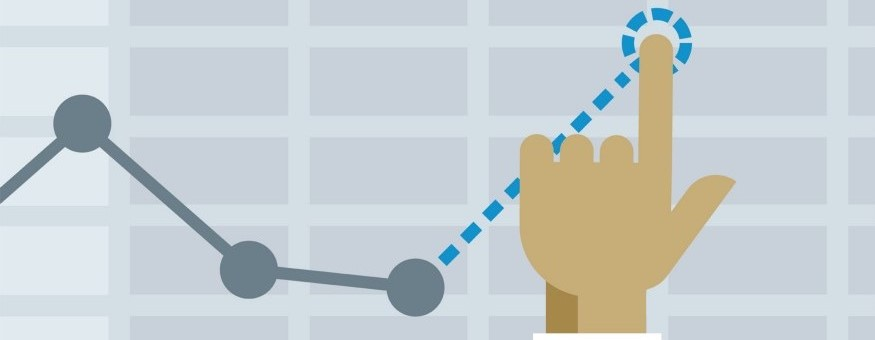

## About this notebook:

&emsp; Demand forecasting is the process of predict the future demand of products or services over a certain period of time to make intelligent business decisions. From inventory or production planning, warehouses and supply-chain, to price optimization and recommendations systems, it is crucial for the business to understand what is likely to happen in the near future.

&emsp; The goal behind this notebook is to solve the demand forecasting of products problem using different approaches. The data to be used throughout this study is from a manufacturing company and was available on Kaggle website. More information can be found below. The objective is to obtain between one and three months up front forecast, in order to provide the company with valuable intelligence to plan their production and supply-chain processes.

&emsp; This notebook is subdivided in 5 main parts. Firstly, a data cleaning, exploration and preparation was conducted in order to obtain a consistent time series be studied. The warehouse and product category having more data available were selected to be analyzed. On the next stages, forecasting values for order demand were generated through the SARIMA model, the Facebook Prophet package and a LSTM Recurrent Neural Network. Lastly, the results of the three methods plus a baseline model were compared through different metrics against the held out set (test set).

## Dataset

The dataset analyzed was provided by FelixZhao on Kaggle website.

https://www.kaggle.com/felixzhao/productdemandforecasting

Below, FelixZhao's data description:

### Data Context
&emsp; The dataset contains historical product demand for a manufacturing company with footprints globally. The company provides thousands of products within dozens of product categories. There are four central warehouses to ship products within the region it is responsible for. Since the products are manufactured in different locations all over the world, it normally takes more than one month to ship products via ocean to different central warehouses. If forecasts for each product in different central with reasonable accuracy for the monthly demand for month after next can be achieved, it would be beneficial to the company in multiple ways.

### Acknowledgements
&emsp; This dataset is all real-life data and products/warehouse and category information encoded.

In [334]:
#Importing main libraries
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import plotly
import statsmodels.api as sm
import fbprophet as Prophet
import cv2
import pmdarima as pm
import warnings
from IPython.display import clear_output
warnings.filterwarnings('ignore')

import datetime as dt
plt.style.use('seaborn')

%matplotlib inline

# Dataset importation
The data type of the 'Date' column was set to datetime64[ns] during the importation.

The dataset contains 1048575 entries from different warehouses, product categories and product codes.


In [335]:
#Import "Forecasts for Product Demand" dataset

df = pd.read_csv('Historical Product Demand.csv', parse_dates = ['Date'])
df.sort_values(by=['Date'], inplace=True)

#Having a look at the data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 44799 to 995794
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1048575 non-null  object        
 1   Warehouse         1048575 non-null  object        
 2   Product_Category  1048575 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1048575 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 48.0+ MB


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
44799,Product_0965,Whse_A,Category_006,2011-01-08,2
72252,Product_1724,Whse_A,Category_003,2011-05-31,108
8431,Product_1521,Whse_S,Category_019,2011-06-24,85000
8432,Product_1521,Whse_S,Category_019,2011-06-24,7000
72669,Product_1507,Whse_C,Category_019,2011-09-02,1250


# Missing values
The column 'Date' has 11239 missing values, which correspond to 1.07 % of the dataset.

This data cannot be used as there is no clue about when they were measured, therefore they will be dropped.

In [336]:
print('\nNumber of NaN values: \n')

#Print NaN values
print(df.isna().sum())
print('\n\nDate column with NaN values: %d (%1.2f %% of the dataset)' %(df.Date.isna().sum(), 100 * df.Date.isna().sum() / df.Date.size ))


Number of NaN values: 

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64


Date column with NaN values: 11239 (1.07 % of the dataset)


In [337]:
#Drop NaN values from 'Date'
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 44799 to 908844
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1037336 non-null  object        
 1   Warehouse         1037336 non-null  object        
 2   Product_Category  1037336 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1037336 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 47.5+ MB


# The Date column

In [338]:
#Check the dates in the dataset
print('First date:', df.Date.min())
print('Last date:', df.Date.max())
    
print('Timedelta:', df.Date.max() - df.Date.min())

First date: 2011-01-08 00:00:00
Last date: 2017-01-09 00:00:00
Timedelta: 2193 days 00:00:00


# The Product Categories column

In [339]:
#Check all the product categories
print('Unique product categories:\n\n',df.Product_Category.unique())
print('\n\nTotal unique product categories:',df.Product_Category.unique().size)

Unique product categories:

 ['Category_006' 'Category_003' 'Category_019' 'Category_001'
 'Category_023' 'Category_011' 'Category_007' 'Category_009'
 'Category_021' 'Category_028' 'Category_004' 'Category_015'
 'Category_024' 'Category_030' 'Category_026' 'Category_018'
 'Category_032' 'Category_013' 'Category_020' 'Category_005'
 'Category_022' 'Category_031' 'Category_010' 'Category_008'
 'Category_033' 'Category_017' 'Category_029' 'Category_025'
 'Category_012' 'Category_014' 'Category_002' 'Category_027'
 'Category_016']


Total unique product categories: 33


# The Product Codes column

In [340]:
#Checking all the product codes
print('Unique products:\n\n',df.Product_Code.unique())
print('\n\nTotal unique products:',df.Product_Code.unique().size)

Unique products:

 ['Product_0965' 'Product_1724' 'Product_1521' ... 'Product_0465'
 'Product_1013' 'Product_0853']


Total unique products: 2160


# The Warehouse column

In [341]:
#Checking all the warehouses

print('Unique warehouses:\n\n',df.Warehouse.unique())
print('\n\nTotal unique warehouses:',df.Warehouse.unique().size)

Unique warehouses:

 ['Whse_A' 'Whse_S' 'Whse_C' 'Whse_J']


Total unique warehouses: 4


# The Order Demand column
Since the Order Demand column had a few non-numeric values, we ae getting rid of those and setting its data type to 'int32'.

In [342]:
#Cleaning up the data, removing " ", "(" and ")"
df.Order_Demand = df.Order_Demand.str.replace(pat=' ', repl = '')
df.Order_Demand = df.Order_Demand.str.replace(pat='(', repl = '')
df.Order_Demand = df.Order_Demand.str.replace(pat=')', repl = '')

#Setting data type as 'int32'
df.Order_Demand = df.Order_Demand.astype('int32')


In [343]:
df.Order_Demand.describe()

count    1.037336e+06
mean     4.949384e+03
std      2.907344e+04
min      0.000000e+00
25%      2.000000e+01
50%      3.000000e+02
75%      2.000000e+03
max      4.000000e+06
Name: Order_Demand, dtype: float64

# Order Demand Analysis

As we are interested in forecasting a specific product category demand for a single warehouse, we are analyzing the demand distribution for different products and warehouses.

It is plotted below the total product demand for each warehouse from 2011-01-08 to 2017-01-09.

From this graph, it is clear that the Warehouse J has the greatest demand.



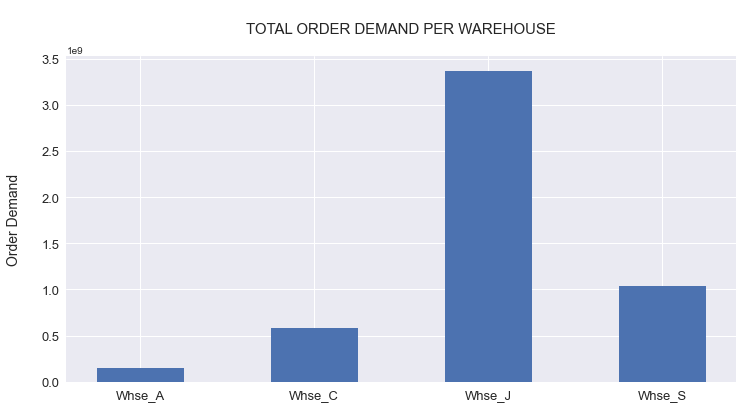

In [344]:
#Prep the data
warehouse = df
warehouse = warehouse.groupby(['Warehouse']).sum()

#Plotting
fig0, ax = plt.subplots(figsize=(12,6))

ax.bar(warehouse.index, warehouse.Order_Demand, width = 0.5)
ax.set_title('\nTOTAL ORDER DEMAND PER WAREHOUSE\n', fontsize=15)
ax.set_ylabel('Order Demand\n', fontsize = 14)
ax.tick_params(axis="x", labelsize=13)
ax.tick_params(axis="y", labelsize=13)

### Product Demand Category per Warehouse

Now we are going a bit further and investigate the product category distribution from each warehouse.

The results show a higher demand for the Product Category 19 in all the cases.


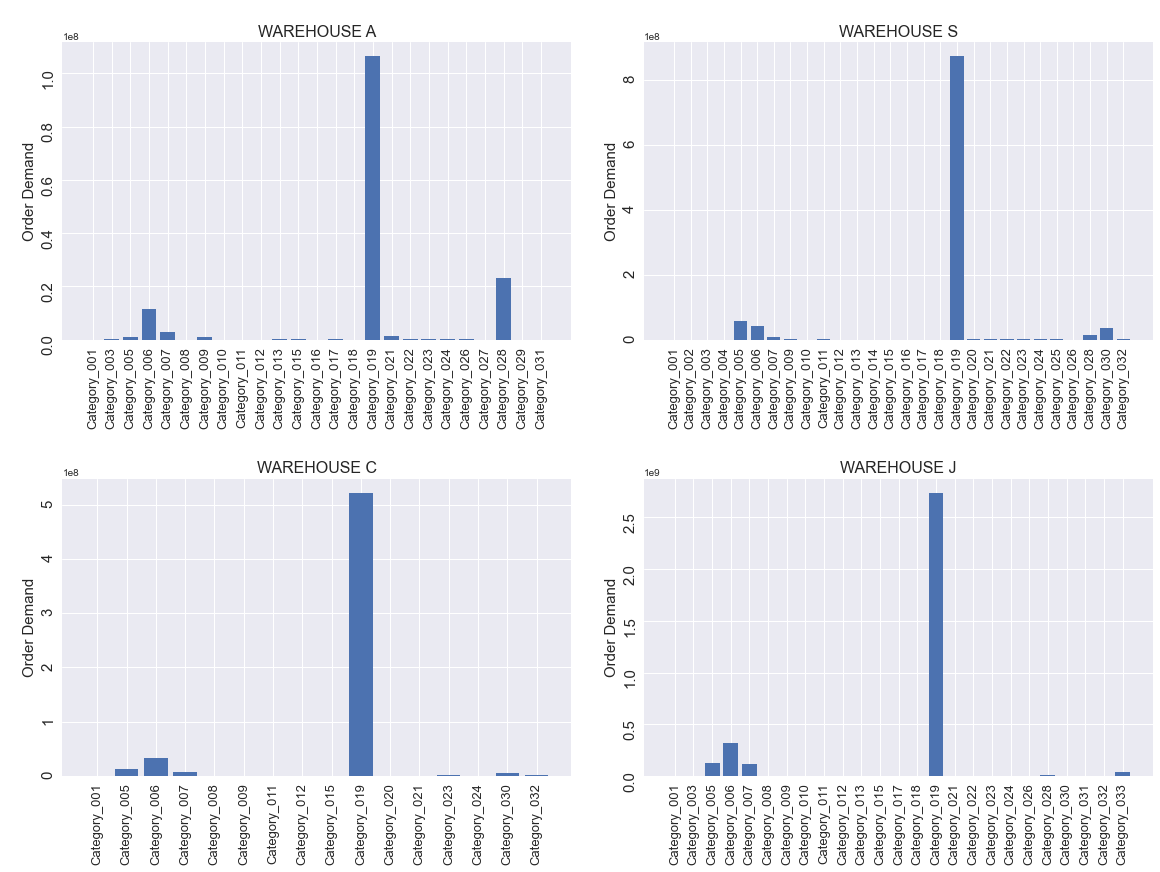

In [345]:
#Defining a function for plotting
def warehourse_prod_cat_plot(axes, warehouse, title):
    title = '\n'+title
    axes.bar(warehouse_cat.loc[warehouse]['Order_Demand'].index, warehouse_cat.loc[warehouse]['Order_Demand'])
    axes.set_title(title, fontsize=16)
    axes.tick_params(labelrotation=90)
    axes.set_ylabel('\nOrder Demand', fontsize=15)
    axes.tick_params(axis="x", labelsize=13)
    axes.tick_params(axis="y", labelsize=15)


warehouse_cat = df.groupby(['Warehouse','Product_Category']).sum()

fig1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16,12), constrained_layout=True)

warehourse_prod_cat_plot(ax1, 'Whse_A', 'WAREHOUSE A')
warehourse_prod_cat_plot(ax2, 'Whse_S', 'WAREHOUSE S')
warehourse_prod_cat_plot(ax3, 'Whse_C', 'WAREHOUSE C')
warehourse_prod_cat_plot(ax4, 'Whse_J', 'WAREHOUSE J')


# TIME-SERIES
# Exploratory Analysis and Data Preparation

Here, we will be preparing the data for analysis in a Time-Series format.

According to what was seen above, the Warehouse J has the highest order demand, specifically regarding the Product Category 19. Hence, this will be the focus of this study.

After filtering the dataset to get the specific information that we are interested in, we should check the frequency of the series. It is important that we have a constant frequency for our Time-Series analysis, so the data was resampled. 

Two datasets were generated, one in monthly frequency and the other one in weekly frequency. 

**Down sampling the data Weekly**

The resampling was made summing up all the values per week:
 - We have the total order per week
 - As the number of orders placed per week vary, the mean values of the quantity ordered cannot be used.

**Down sampling the data - Monthly**

The resampling was made taking the mean of all the values per week:
  - We have the mean order value per week in each month

These will be plotted one on top of the other so we can get a better grasp about the data.

Since our obective is to obtain a consistent forecast for the next months order demand of product, we will be adopting a weekly frequency to conduct the rest of our analysis. This way, there will be more details available to be explored in a short-term forecast and we will be working with the totals.


In [346]:
#Selecting data from Warehouse J regarding Product Category 019
dft = df[(df['Warehouse'] == 'Whse_J') & (df['Product_Category'] == 'Category_019')]

#Setting the column 'Date' as dataframe index
dft.set_index(dft['Date'], inplace=True)
pd.to_datetime(dft.index)

#Downsampling the data - Weekly
dft_week = dft.Order_Demand.resample('W').sum()
dft_week = dft_week.interpolate() # Dealing with missing values by interpolation 
dft_week = dft_week.to_frame(name = 'Order_Demand') #Turning it into a DataFrame again

#Downsampling the data - Monthly
dft_month = dft_week.resample('MS').mean()

#Dropping 2011 data and 2017 first week as there was not much data available
dft_week = dft_week['2012-01-01':'2016-12-31']
dft_month = dft_month['2012-01-01':'2016-12-31']

#Defining our Time-Series DataFrame
dft  = dft_week

## Time-Series Plot
When we plot the Order Demand in a weekly basis and in a monthly basis, one on top of the other, we can see the Order Demand-monthly being steadier. This is expected, as the monthly frequency is an average of the weekly series.

Below, it is plotted a histogram showing the distribution of the Order Demand.

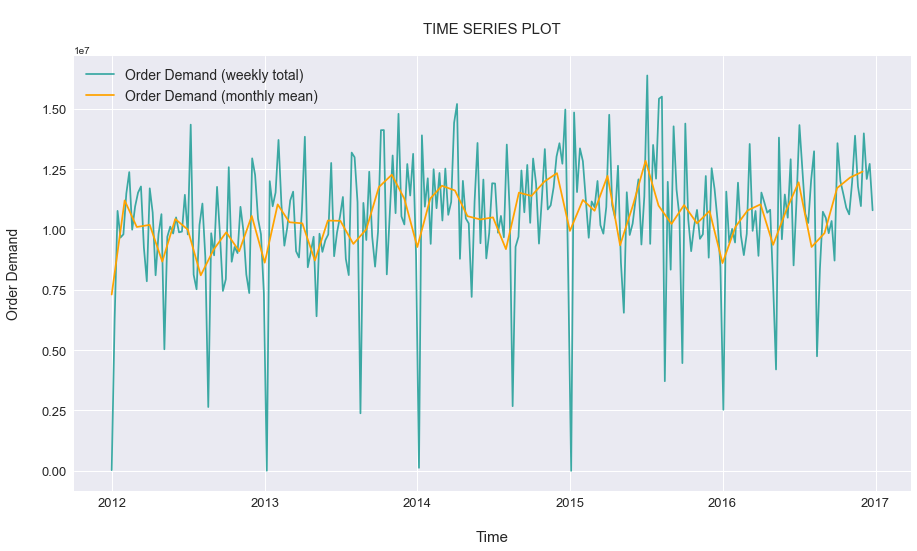

In [347]:
#Ploting the signals - Monthly and weekly
fig, ax = plt.subplots(figsize = (15,8))

ax.plot(dft_week, color = '#0F9890', label='Order Demand (weekly total)', alpha=0.8)
ax.plot(dft_month, color = '#ffa300', label='Order Demand (monthly mean)')


ax.set_title('\nTIME SERIES PLOT\n', fontsize=15)
ax.tick_params(axis="x", labelsize=13)
ax.set_ylabel('Order Demand\n', fontsize=14)
ax.set_xlabel('\nTime', fontsize=15)
ax.tick_params(axis="y", labelsize=13)
ax.legend(fontsize=14, loc=2)

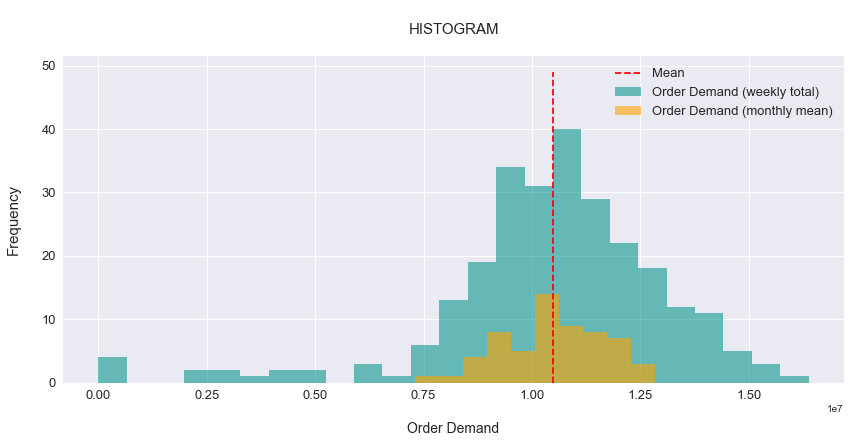

In [348]:
fig, ax = plt.subplots(figsize = (14,6))

ax.hist(dft_week, color = '#0F9890', bins =25, label = 'Order Demand (weekly total)', alpha=0.6)
ax.hist(dft_month, color = '#ffa300', bins =10, label = 'Order Demand (monthly mean)', alpha=0.6)
ax.set_title('\nHISTOGRAM\n', fontsize=15)
ax.tick_params(axis="x", labelsize=13)
ax.set_ylabel('Frequency\n', fontsize=15)
ax.set_xlabel('\nOrder Demand', fontsize=14)
ax.tick_params(axis="y", labelsize=13)
ax.plot(np.ones(50)*dft_week.Order_Demand.mean(), np.arange(50), color='red', linestyle='--', label = 'Mean')
ax.legend(fontsize=13)

## Seasonal Plot

Annual seasonality assessment.

We can identify some patterns about the order demand throughout the year in the graph below. 

In general, all the years in the analysis have a slow start in January, probably an effect from the first week of the year, then go up in next three months. In May the demand seems to drop, get high again in July and then drop once again in August. From this point on, the demand increases slowly until the final of the year.

This behavior indicates the presence of seasonality. It can also be identified in the Time-Series Plot above, where clearly certain weeks of the year have low number of orders, systematically.


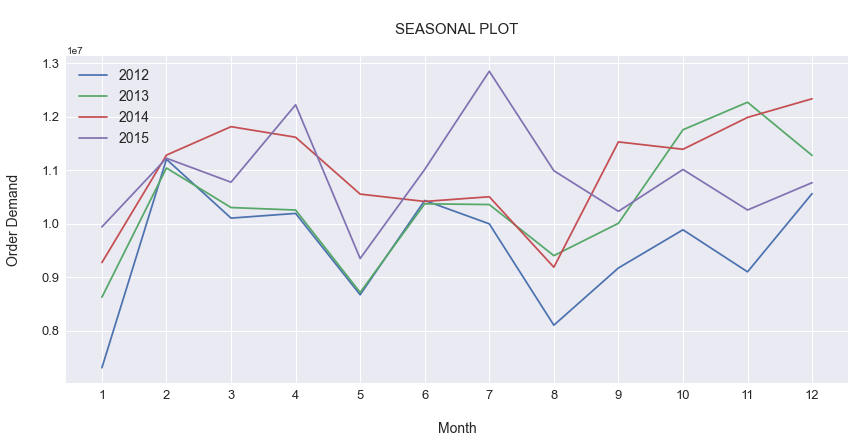

In [349]:
dft_month['Month'] = dft_month.index.month
dft_month['Year'] = dft_month.index.year

year = dft_month['Year'].unique()
year = np.delete(year,-1)

fig, ax = plt.subplots(figsize=(14,6))

for i in year:
    ax.plot(dft_month[dft_month['Year'] == i]['Month'], dft_month[dft_month['Year'] == i]['Order_Demand'], label=i)


ax.legend(fontsize=14)
ax.set_title('\nSEASONAL PLOT\n', fontsize=15)
ax.tick_params(axis="x", labelsize=13)
ax.set_xticks(dft_month['Month'].unique())
ax.set_ylabel('Order Demand\n', fontsize=14)
ax.set_xlabel('\nMonth', fontsize=14)
ax.tick_params(axis="y", labelsize=13)

## Signal Decomposition

Through the signal decomposition, it is possible to assess the trend, seasonal and residual components separately.
The series was modeled as addictive and the frequency was chosen was 52 weeks (roughly one year).

Analyzing the residuals, we can note the presence of a few outliers that would not be contributing to the improvement of our forecast. It is always important to investigate and try to understand the context of the outliers before taking any action. In this case, however, we have no information about these data points and therefore they will be removed. It was used the 1.5*IQR Method for outlier detection and they were replaced with a linear interpolation between their preceding and subsequent points.


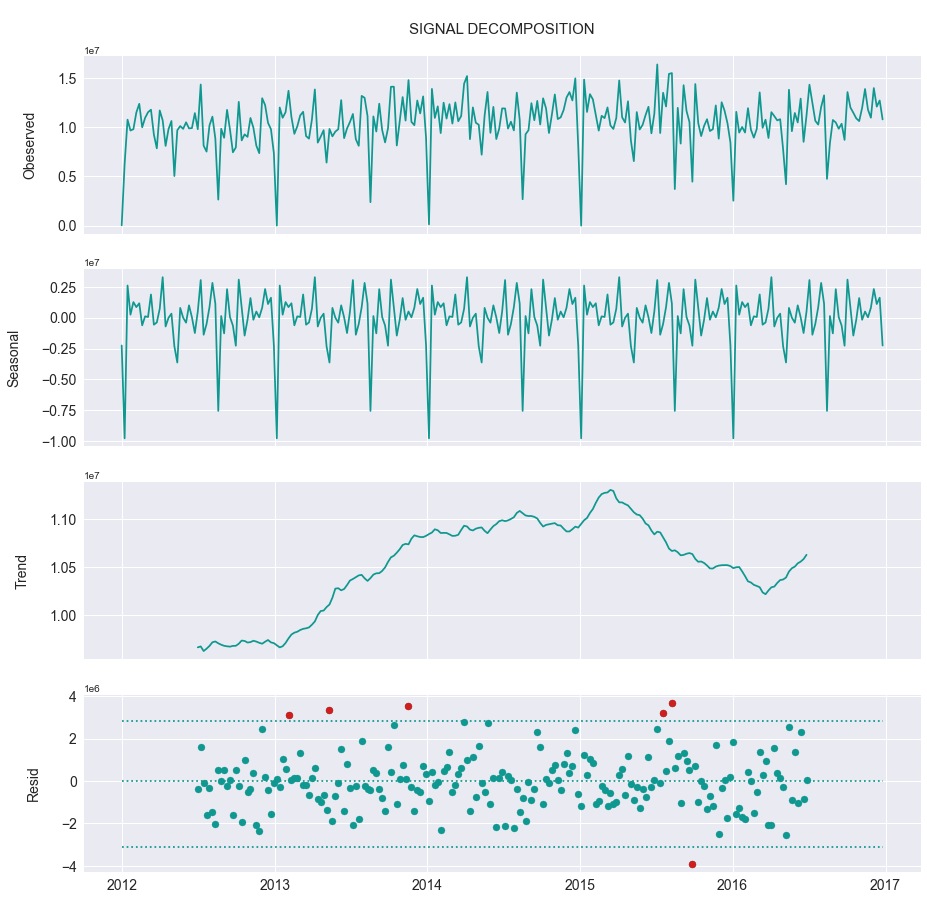

In [350]:
#Get the decomposed signal
dec = sm.tsa.seasonal_decompose(dft.Order_Demand, model='addictive',freq=52)



#Define a function to detect outliers
def get_outlier(dec_func):
    '''   
    The function returns the set of outliers points present in the data set.
    The detection is made through 1.5 IQR
    
    dec_func = residuals from the seasonal decompose  
    '''
    dec_func = dec_func.dropna()
    
    q1 = dec_func.quantile(0.25)
    q3 = dec_func.quantile(0.75)
    iqr = q3 - q1
    filt = (dec_func <= (q1 - 1.5*iqr)) + (dec_func >= (q3 + 1.5*iqr))

    return dec_func[filt]




#Define a function set up each individual plot of the decomposed signal
def signal_dec_plot_individual(ax, dec_func, ylabel, plottype='general'):    
    
    #Plot settings
    ylabel=ylabel+'\n'
    ax.set_ylabel(ylabel, fontsize=14)
    ax.tick_params(axis="x", labelsize=14)   
    ax.tick_params(axis="y", labelsize=14)

    #Check weather it is a resid plot or a general plot - If residual, plot the outliers limits (1.5 IQR)
    if plottype == 'resid':    
        outliers = get_outlier(dec_func.dropna())
        q1 = dec_func.dropna().quantile(0.25)
        q3 = dec_func.dropna().quantile(0.75)  
        iqr = q3 - q1
        ax.scatter(dec_func.index, dec_func, color = '#0F9890')
        ax.scatter(outliers.index, outliers, color = 'red', alpha=0.8)
        ax.plot([dec_func.index.min(),dec_func.index.max()], [0,0], color = '#0F9890', linestyle=':')
        ax.plot([dec_func.index.min(),dec_func.index.max()], [q1-1.5*iqr,q1-1.5*iqr], color = '#0F9890', linestyle=':')
        ax.plot([dec_func.index.min(),dec_func.index.max()], [q3+1.5*iqr,q3+1.5*iqr], color = '#0F9890', linestyle=':')
    else: 
        ax.plot(dec_func, color = '#0F9890')         
  
    
              
#Define a function to plot the decomposed signal        
def signal_dec_plot(func, figsize=(15,15)):
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = figsize, sharex = True)
    
    ax1.set_title('\nSIGNAL DECOMPOSITION\n', fontsize=15)
    
    
    
    signal_dec_plot_individual(ax1, func.observed, 'Obeserved')
    signal_dec_plot_individual(ax2, func.seasonal, 'Seasonal')
    signal_dec_plot_individual(ax3, func.trend, 'Trend')
    signal_dec_plot_individual(ax4, func.resid, 'Resid', plottype='resid')


#Plot the decomposed signal
signal_dec_plot(dec)



In [351]:
#Replacing the outliers values shown above by interpolation
#The first datapoint was dropped too
outliers = get_outlier(dec.resid)       
dft.Order_Demand[outliers.index] = np.nan
dft.Order_Demand = dft.Order_Demand.interpolate()


Plotting the time-series again, after the outlier removal.

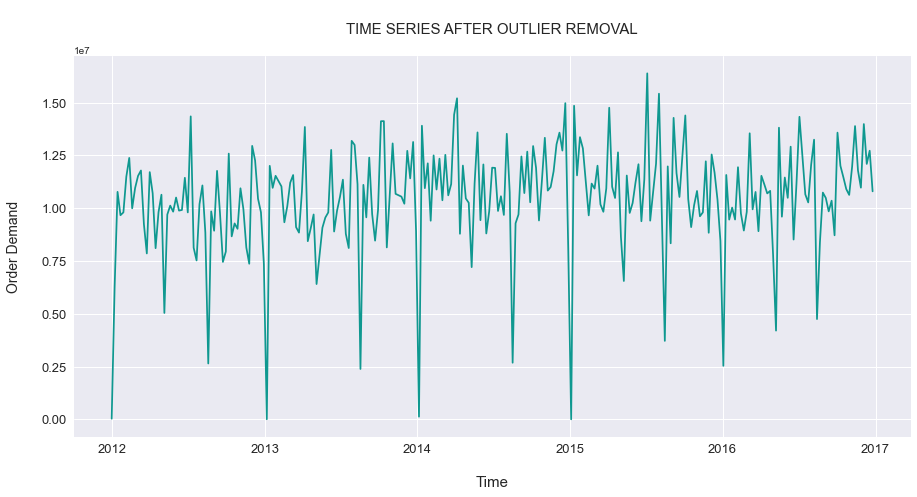

In [352]:
def ts_plot(ts, title):
    fig, ax = plt.subplots(figsize = (15,7))

    ax.plot(ts, color = '#0F9890')
    ax.set_title(title, fontsize=15)
    ax.tick_params(axis="x", labelsize=13)
    ax.set_ylabel('Order Demand\n', fontsize=14)
    ax.set_xlabel('\nTime', fontsize=15)
    ax.tick_params(axis="y", labelsize=13)

    
ts_plot(dft.Order_Demand, '\nTIME SERIES AFTER OUTLIER REMOVAL\n')

## Augmented Dickey-Fuller Test
Applying Augmented Dickey-Fuller Test for staionarity check.

The test resulted in a very low p-value, hence the null hypothesis can be rejected and the series is likely to be stationary. The Augmented Dickey-Fuller Test accounts especially for autocorrelation, so it is important to check stationarity through other methods as well.

In [353]:
#Setting a Augmented Dickey-Fuller Test function

import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [354]:
#Augmented Dickey-Fuller Test
dftest(dft.Order_Demand)

Test Statistic         -1.267068e+01
p-value                 1.246478e-23
Lags Used               1.000000e+00
Observations Used       2.590000e+02
Critical Value (1%)    -3.455853e+00
Critical Value (5%)    -2.872765e+00
Critical Value (10%)   -2.572752e+00
dtype: float64


# ACF and PACF plots

From these plots it is possible to get a clue about what sort of model to use.

Here it is clear the presence of seasonality in the series, we can note those large spikes around the weeks 52 and 104. These spikes mean we should model the data through a method that accounts for seasonality, in this case, SARIMA will be used.
It is also possible to infer that it is needed to differentiate the data.


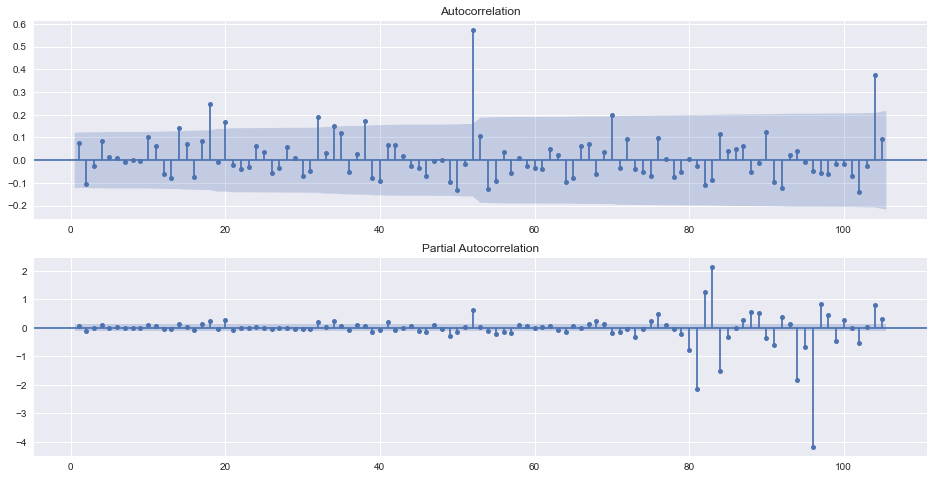

In [355]:
def acf_pacf_plot(dataframe, lags=105):

    fig, (acf, pacf) = plt.subplots(2,1, figsize = (16,8))
    a = sm.tsa.graphics.plot_acf(dataframe, ax=acf, lags= lags, zero=False)
    b = sm.tsa.graphics.plot_pacf(dataframe, ax=pacf, lags= lags, zero=False)

    
acf_pacf_plot(dft.Order_Demand)    

# Training and Test sets

Spliting the time-series into the training and test sets.

As the objective is to generate short-term forecasts, forecasting the order demand for one to three ahead months, the test set will be set to 12 steps.

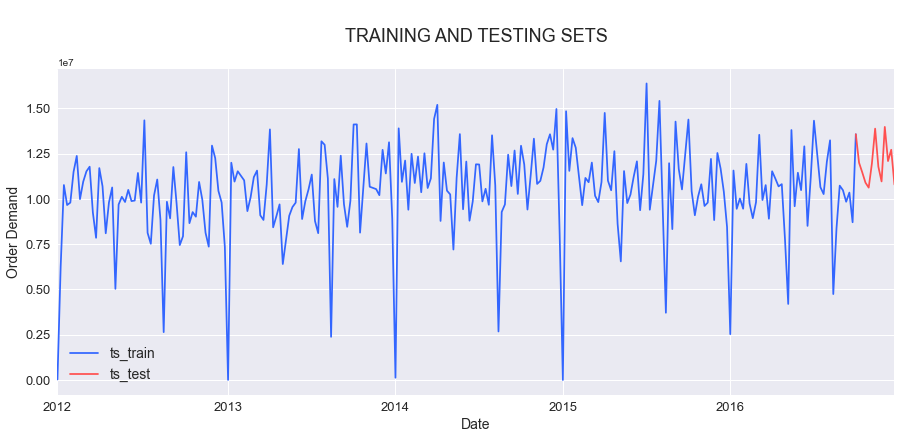

In [23]:
#Defining Training and Test sets

#How many steps there will be in the test set
n_test = 12  #3 months

train_test_div = dft.size - n_test
ts_train = dft.Order_Demand[:train_test_div]
ts_test = dft.Order_Demand[(train_test_div-1):]


#plot
plt.tick_params(axis="x", labelsize=13)   
plt.tick_params(axis="y", labelsize=13)
plt.title('\nTRAINING AND TEST SETS\n', fontsize=18)
plt.ylabel('Order Demand', fontsize=14)
plt.xlabel('Time', fontsize=14)
ts_train.plot(figsize=(15,6), label='ts_train', color = "#3366ff")
ts_test.plot(label='ts_test', color='#ff5050')
plt.legend(fontsize=14)

#Defining whole set as a pandas series
whole_set = dft.Order_Demand

# SARIMA Model

The first forecasting method applied to this time-series is SARIMA. SARIMA stands for Seasonal ARIMA, being an extension of the autoregressive integrated moving average (ARIMA) model, that encompasses the seasonal component.

For SARIMA it is necessary to set 6 parameters (p,d,q)(P,D,Q).

These parameters will be selected through a 2 steps Grid Search, where we fit our model using different (p,d,q)(P,D,Q)s. Firstly, we will fit the model to the whole series and look for the best AIC.

Secondly, the 20 best models from the previous step will be fitted to the training set and their performance will be measured in the test set using the RMSE.

It is expected that in the first step we select a few models that fit well the data and in the second step the model that best forecast the test data will be elected.

**Note:** It is known that using the test set for model and hyperparameter selection is not a good practice and it should be done through a validation set or cross validation methods, however for simplicity, this case will be conducted this way.

## First step GRID SEARCH - The Akaike Information Criterion

The AIC is applied to the Grid Search where the model is fitted to the whole series.

A ranking table is presented below with the best models and their scores.

In [24]:
import itertools



#Defining a function to extract a specific model from modelfrom a rank DataFrame

def extract_model(indexx, model_DataFrame):
    '''
    
    Extracts a model from a DataFrame.
    
    Arguments
    ------------
    indexx: Index of the model to be extracted from the model_DataFrame
    model_DataFrame: The ranking data frame
    
    
    Return
    ------------
    model_extracted: List like [AIC, [p, d, q], [P, D, Q], 't']
    order_set: List like [p, d, q]
    seasonal_order_set: List like [P, D, Q]
    trend: String like 't'
    
    '''
    #Get the model_extracted from the dataframe
    model_extracted = []
    model_extracted.append(model_DataFrame.iloc[indexx,0])
    
    #Get the trend from the dataframe
    trend = model_DataFrame.iloc[indexx,7]
    
    #Get the order_set and seasonal_order_setfrom the dataframe
    order_set = []
    seasonal_order_set = []
    
    for i in range(3):
        #Get the order_set from the dataframe
        order_set.append(int(model_DataFrame.iloc[indexx,i+1]))
        seasonal_order_set.append(int(model_DataFrame.iloc[indexx,i+4]))
    
    #Wrap up 
    model_extracted.append(order_set)
    model_extracted.append(seasonal_order_set)
    model_extracted.append(trend)
    
    return model_extracted, order_set, seasonal_order_set, trend









#Defining a function to return a DataFrame with the best models based on the AIC

def rank_ARIMA_AIC(p, d, q, seasonal_pdq, trend, whole_set, rank_size=20):
    '''
    
    Run a grid search to select the best models using AIC metric.
    
    
    Arguments
    ------------
    whole_set: Dataset where the model will be evaluated.
    p, d, q, seasonal_pdq, trend: Parameters to from the model/
    
    
    Return
    ------------  
    m_ranking: Data frame with the best models.
    best_model: Best model extracted.
    '''
    
    pdq = list(itertools.product(p, d, q))


    #Create the model ranking DataFrame
    m_ranking = pd.DataFrame({'AIC': np.full([rank_size], np.nan), 
                              'Order_1': np.zeros(rank_size), 
                              'Order_2': np.zeros(rank_size),
                              'Order_3': np.zeros(rank_size),
                              'Seasonal_Order1': np.zeros(rank_size), 
                              'Seasonal_Order2': np.zeros(rank_size),
                              'Seasonal_Order3': np.zeros(rank_size),
                              'Trend': np.full([rank_size], np.nan),
                              'RMSE': np.zeros(rank_size)})

    
    #Fit the model with different parameters
    for trend_param in trend:
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    model_AutoARIMA = sm.tsa.statespace.SARIMAX(whole_set,
                                                    order=param,
                                                    seasonal_order=param_seasonal,
                                                    enforce_stationarity=False,
                                                    trend = trend_param,
                                                    enforce_invertibility=False)

                    results = model_AutoARIMA.fit()
                except:
                    print('EXCEPTION!')
                    continue
                    
                    
                    

                #Update the rankign Dataset when the actual model perfroms worse than the worst model in the ranking
                if m_ranking.iloc[-1].AIC > results.aic or pd.isna(m_ranking.iloc[-1].AIC):

                    #Update the last line in the table (replace the worst model ranked so far)
                    m_ranking.iloc[-1,0] = results.aic
                    m_ranking.iloc[-1,7] = trend_param

                    for i in range(3):
                        m_ranking.iloc[-1,i+1] = param[i]
                        m_ranking.iloc[-1,i+4] = param_seasonal[i]

                    #Display the model                 
                    m_ranking.sort_values('AIC', inplace=True)
                    clear_output()
                    print('Model added to the RANK: {} - {} x {} x - "{}"'.format(results.aic, param, param_seasonal, trend_param))                       
                    
                print('Looping!')
                
    clear_output()             
    m_ranking = m_ranking.reset_index(drop=True)
    best_model = extract_model(0, m_ranking)
    return m_ranking, best_model


In [282]:
#Defining the moldel's parameters for ranking

#Order
p = range(0, 6)
d = range(0, 2)
q = range(1, 6)

#Seasonal order
seasonal_pdq = [(2,2,0,52),(2,2,1,52), (1,2,0,52), (1,2,1,52), (2,0,0,52),(2,1,1,52), (0,2,0,52), (0,1,0,52)]
# P = D = Q = range(3)
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

#Trend
trend = ['c']
# trend = ['n','c']


#Call the rank_ARIMA_AIC function and display the results
rank, best_model = rank_ARIMA_AIC(p, d, q, seasonal_pdq, trend=trend, whole_set=whole_set)
rank

,AIC,Order_1,Order_2,Order_3,Seasonal_Order1,Seasonal_Order2,Seasonal_Order3,Trend,RMSE
0,26.000000,5.0,1.0,3.0,2.0,1.0,1.0,c,0.0
1,1524.015319,5.0,1.0,1.0,2.0,2.0,1.0,c,0.0
2,1525.426165,5.0,1.0,2.0,2.0,2.0,1.0,c,0.0
3,1528.317490,5.0,1.0,3.0,2.0,2.0,1.0,c,0.0
4,1531.844173,5.0,1.0,2.0,2.0,2.0,0.0,c,0.0
5,1532.465132,5.0,1.0,1.0,2.0,2.0,0.0,c,0.0
6,1533.095112,5.0,1.0,3.0,2.0,2.0,0.0,c,0.0
7,1538.197617,5.0,1.0,5.0,2.0,2.0,0.0,c,0.0
8,1539.479869,5.0,1.0,5.0,2.0,2.0,1.0,c,0.0
9,1540.504012,5.0,1.0,4.0,2.0,2.0,1.0,c,0.0


## Second step GRID SEARCH - Root Mean Square Error

The RMSE is applied to the second step Grid Search. The models are fitted to the training set and their performance is measured in the test set.

A ranking table is presented below with the best models and their scores.

In [283]:
#Forecast metrics
def rmse_calc(y, yhat):
    '''RMSE'''
    rmse = np.sqrt(np.mean((y - yhat)**2))
    return rmse


def rmse_pct_calc(y, yhat):
    '''RMSE%'''
    rmse_pct = (np.sqrt(np.mean((y - yhat)**2))) / np.mean(y)
    return rmse_pct


def mae_calc(y, yhat):
    '''MAE'''
    mae = np.mean(np.abs(y - yhat))
    return mae


def mape_calc(y, yhat):
    '''MAPE'''
    mape = np.mean((np.abs(y - yhat))/y)
    return mape


def forecast_metrics(y, yhat, fct_name='Model'):
    '''Sumarize metrics into a dataframe.'''
    
    metrics = {'Metric':['RMSE', 'RMSE%', 'MAE', 'MAPE'],
             fct_name:[rmse_calc(y, yhat),  rmse_pct_calc(y, yhat),  mae_calc(y, yhat),  mape_calc(y, yhat) ]}
    
    return pd.DataFrame(metrics)


#Defining a function to rank models based on the RMSE applied to the test set
def rank_ARIMA_RMSE(m_ranking, ts_train, ts_test):
    '''
    
    Run a grid search to select the best models using RMSE metric applied to the test set.
    
    
    Arguments
    ------------
    m_ranking: Data frame with the best models sorted by the AIC metric.
    ts_train: Training set.
    ts_test: Test set.
    
    
    Return
    ------------
    m_ranking: Data frame with the best models sorted by the RMSE metric.
    best_model: Best model extracted.
    '''

    for i in range(m_ranking.index.size):
        
        model, order, seasonal_order, trend = extract_model(i, m_ranking)

        seasonal_order.append(52)

        try:
            #Fit the model
            model_AutoARIMA = sm.tsa.statespace.SARIMAX(ts_train,
                                                order=order,
                                                seasonal_order=seasonal_order,
                                                trend = trend,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
            results = model_AutoARIMA.fit()
        except: 
            print('Fitting problem...')
            continue
            

        #RMSE
        rmse = rmse_calc(ts_test[1:], results.get_forecast(ts_test.size).predicted_mean[:-1])
   
        #Update RMSE in the table
        m_ranking.iloc[i,8] = rmse 
            

    m_ranking.sort_values('RMSE', inplace=True)
    m_ranking = m_ranking.reset_index(drop=True)
    best_model = extract_model(0, m_ranking)
    return m_ranking, best_model

In [284]:
rank, best_model  = rank_ARIMA_RMSE(rank, ts_train, ts_test)
print(best_model)
rank

([1557.0667459145548, [5, 0, 1], [2, 2, 1], 'c'], [5, 0, 1], [2, 2, 1], 'c')


,AIC,Order_1,Order_2,Order_3,Seasonal_Order1,Seasonal_Order2,Seasonal_Order3,Trend,RMSE
0,1557.066746,5.0,0.0,1.0,2.0,2.0,1.0,c,1.899109e+06
1,1561.499138,5.0,0.0,4.0,2.0,2.0,1.0,c,2.288855e+06
2,1560.044543,5.0,0.0,3.0,2.0,2.0,1.0,c,2.381577e+06
3,1524.015319,5.0,1.0,1.0,2.0,2.0,1.0,c,2.791559e+06
4,1562.544012,5.0,0.0,1.0,2.0,2.0,0.0,c,2.797015e+06
5,1556.543228,4.0,1.0,1.0,2.0,2.0,1.0,c,2.923026e+06
6,1525.426165,5.0,1.0,2.0,2.0,2.0,1.0,c,3.066644e+06
7,1563.474327,5.0,0.0,3.0,2.0,2.0,0.0,c,3.074126e+06
8,1540.504012,5.0,1.0,4.0,2.0,2.0,1.0,c,3.630430e+06
9,1528.317490,5.0,1.0,3.0,2.0,2.0,1.0,c,3.774807e+06


## Fitting the model

In [289]:
#Get the best model parameters (pdqPDQ) - Values extracted from the ranking dataframe
param, order, s_order, trend = extract_model(0, rank) 

# order = [0,1,4]
# s_order = [2,0,0]
# trend = 'c'
s_order.append(52)

print('\nModel selected:\n')
print('order = ', order)
print('seasonal order = ',s_order)
print('trend = ',trend)


Model selected:

order =  [5, 0, 1]
seasonal order =  [2, 2, 1, 52]
trend =  c


In [290]:
#Fitting the model
m_ARIMA = sm.tsa.statespace.SARIMAX(ts_train, 
                                order=order, 
                                seasonal_order=s_order,
                                trend=trend,    
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()
m_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       Order_Demand   No. Observations:                  249
Model:             SARIMAX(5, 0, 1)x(2, 2, 1, 52)   Log Likelihood                -575.732
Date:                            Mon, 22 Feb 2021   AIC                           1173.463
Time:                                    08:18:33   BIC                           1190.882
Sample:                                01-01-2012   HQIC                          1179.543
                                     - 10-02-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.957e+05   2.82e-06   -1.4e+11      0.000   -3.96e+05   -3.96e+05
ar.L1         -0.3617      2.349     -0.154      0.878      -4.965       4.242
ar.L2         -0.0919      0.727     -0.126      0.899      -1.517       1.333
ar.L3         -0.1299      0.620     -0.209      0.834      -1.346       1.086
ar.L4          0.0044      0.567      0.008      0.994      -1.107       1.116
ar.L5          0.2115      0.576      0.367      0.713      -0.917       1.340
ma.L1          0.1651      2.452      0.067      0.946      -4.640       4.970
ar.S.L52      -0.6046      0.663     -0.912      0.362      -1.905       0.695
ar.S.L104     -0.1898      0.869     -0.218      0.827      -1.893       1.514
ma.S.L52      -0.9523      0.192     -4.954      0.000      -1.329      -0.576
sigma2      8.614e+12   1.79e-13   4.82e+25      0.000    8.61e+12    8.61e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.83
Prob(Q):                              0.88   Prob(JB):                         0.66
Heteroskedasticity (H):               1.15   Skew:                             0.23
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.35e+42. Standard errors may be unstable.
"""

## Model Diagnostics


In [291]:
try:
    m_ARIMA.plot_diagnostics(figsize = (15,8))
except: 
    print()
    print('There was a problem running diagnostics of the model, it could be caused by non stationarity or non invertibility.')
    print()
    
    
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = m_ARIMA.test_normality('jarquebera')[0]
lb_val, lb_p = m_ARIMA.test_serial_correlation(method='ljungbox',)[0]
het_val, het_p = m_ARIMA.test_heteroskedasticity('breakvar')[0]


# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(
    m_ARIMA.filter_results.standardized_forecasts_error[0, m_ARIMA.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))


There was a problem runnigs diagnostics of the model, it could be caused by non stationarity or non invertibility.

Normality: val=0.826, p=0.662
Ljung-Box: val=2.166, p=0.950
Heteroskedasticity: val=1.146, p=0.817
Durbin-Watson: d=1.98


<Figure size 1080x576 with 0 Axes>

## Forecasting Plot

Predicted + forecast values by the model against the actual data points.

It is set a forecast horizon of 8 weeks plus the forecast period for the test data. Therefore, the model is forecasting 20 weeks in total.

The confidence interval is set to 80% or alpha = 0.2



In [311]:
#Horizon to forecast (after the test period forecast)
horizon = 8

#Confidence interval alpha
alpha = 0.2

#Getting a results data frame

#Build a full series containing predicted values and forecast values - for the MEAN
ts_ARIMA = m_ARIMA.predict()
ts_ARIMA = pd.concat((ts_ARIMA, (m_ARIMA.get_forecast(ts_test.size + horizon).predicted_mean)), axis=0)

#Build a full series containing predicted values and forecast values - for the CI   
ci_ARIMA = (m_ARIMA.get_prediction().conf_int(alpha = alpha))
ci_ARIMA = pd.concat((ci_ARIMA, (m_ARIMA.get_forecast(ts_test.size + horizon).conf_int(alpha = alpha))), axis=0)



def forecasting_plot(model_pred_mean, model_pred_ci, ts_train, ts_test, horizon, alpha,
                     title='PRODUCT DEMAND FORECASTING - SARIMA\n', ylabel='Order Demand\n', xlabel='\nTime',
                     label_train='SARIMA training',label_forecast_test='SARIMA forecast test',label_forecast='SARIMA forecast'):


    '''
    label_train = ...
    label_forecast_test = ...
    label_forecast = ...
    
    model_pred_mean = DataFrame with datatime index containing the predicted and forecast values for the mean
    model_pred_ci = DataFrame with datatime index containing the predicted and forecast values for the confidence intervals. 
                    **Column 0 = lower CI and Column 1 = upper CI (Using ILOC to get the columns)
    
    ts_train = data used to train the model
    ts_test = data to be used to test the model values
    
    '''

    #Plot
    fig, ax = plt.subplots(figsize = (17,8))

    ax.plot(ts_train, label='Training set', color='#3366ff', alpha=1) #Plot train dataset
    ax.plot(ts_test, label='Test set', color='red', alpha=0.6) #Plot test dataset





    #___MEAN___

    #Split the full series into training, test forecast (forecast values which can be compared to the test values) and forecast

    #train
    ts_ARIMA_training = model_pred_mean[:ts_train.size]
    ax.plot(ts_ARIMA_training, label=label_train, color='#6587FF', linestyle='--', alpha=0.9)

    #forecast test
    ts_ARIMA_fct_test = model_pred_mean[ts_train.size-1:(ts_train.size+ts_test.size-1)]
    ax.plot(ts_ARIMA_fct_test, label=label_forecast_test, color='red', linestyle='--', alpha=0.7)

    #forecast
    ts_ARIMA_fct = model_pred_mean[(ts_test.size+ts_train.size-2):(ts_test.size+ts_train.size+horizon)]
    ax.plot(ts_ARIMA_fct, label=label_forecast, color='green', linestyle='--', alpha=0.7)



    #___CONFIDENCE INTERVAL___

    #Split the full series into training, test forecast (forecast values which we can compare to the test values) and forecast

    #train
    ci_ARIMA_training = model_pred_ci[:ts_train.size]
    ax.fill_between(ci_ARIMA_training.index,
                     ci_ARIMA_training.iloc[:,0],
                     ci_ARIMA_training.iloc[:,1],
                     color='blue', alpha=.1)

    #forecast test
    ci_ARIMA_fct_test = model_pred_ci[ts_train.size-1:(ts_train.size+ts_test.size-1)]
    ax.fill_between(ci_ARIMA_fct_test.index,
                     ci_ARIMA_fct_test.iloc[:,0],
                     ci_ARIMA_fct_test.iloc[:,1],
                     color='red', alpha=.1)

    #forecast
    ci_ARIMA_fct = model_pred_ci[(ts_test.size+ts_train.size-2):(ts_test.size+ts_train.size+horizon)]
    ax.fill_between(ci_ARIMA_fct.index,
                     ci_ARIMA_fct.iloc[:,0],
                     ci_ARIMA_fct.iloc[:,1],
                     color='#8CE078', alpha=.3)

    
    ax.set_title(title, fontsize=15)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=15)
    ax.tick_params(axis="y", labelsize=13)
    ax.tick_params(axis="x", labelsize=12, labelrotation=90)
    ax.grid(b=True, which='minor', axis='both')
    ax.set_xticks(model_pred_mean.index)

    ax.legend(fontsize = 14, loc=2)
    ax.set_ylim(-0.2e7,2.3e7)
    ax.set_xlim(16690,model_pred_mean.index.max())

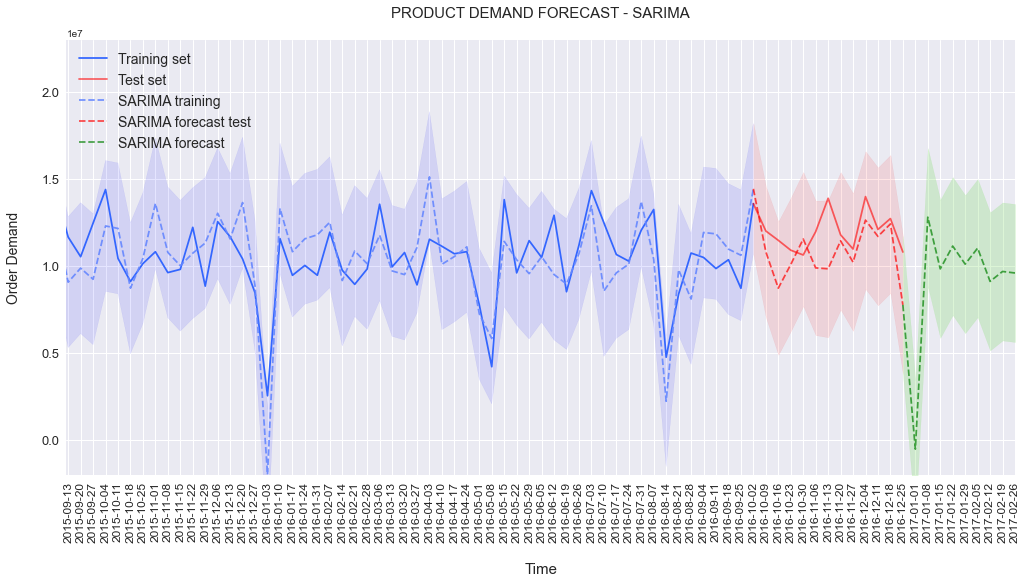

In [312]:
forecasting_plot(ts_ARIMA, ci_ARIMA, ts_train, ts_test, horizon, alpha)

## Model Metrics

The model's performance is presented below. It was measured though four metrics.

RMSE: Root mean squared error

RMSE%: Root mean squared error percentage

MAE: Mean absolute error

MAPE: Mean absolute percentage error

In [294]:
results_SARIMA = forecast_metrics(ts_test[1:], m_ARIMA.get_forecast(ts_test.size).predicted_mean[:-1], 'SARIMA')
results_SARIMA

,Metric,SARIMA
0,RMSE,1.899109e+06
1,RMSE%,1.591595e-01
2,MAE,1.501583e+06
3,MAPE,1.250573e-01


# Animation Script

This script generates a video animation of the SARIMA forecasting plot.

In [459]:
#Horizon to forecast
horizon = 8

#Confidence interval alpha
alpha = 0.2



#Build a full series containing predicted values and forecast values - for the MEAN
ts_ARIMA = m_ARIMA.predict()
ts_ARIMA = pd.concat((ts_ARIMA, (m_ARIMA.get_forecast(ts_test.size + horizon).predicted_mean)), axis=0)



#Build a full series containing predicted values and forecast values - for the CI   
ci_ARIMA = (m_ARIMA.get_prediction().conf_int(alpha = alpha))
ci_ARIMA = pd.concat((ci_ARIMA, (m_ARIMA.get_forecast(ts_test.size + horizon).conf_int(alpha = alpha))), axis=0)


#Set up the video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
video=cv2.VideoWriter('Animation/video.avi', fourcc, 4, (1027, 585))


#FRAMES CREATION
for i in range(78):
    
    i = i+193
    #Plot
    fig, ax = plt.subplots(figsize = (17,8))

    ax.plot(ts_train, label='Training set', color='#3366ff', alpha=1) #Plot train dataset
    ax.plot(ts_test, label='Test set', color='red', alpha=0.6) #Plot test dataset



      


#TRAINING SET
    
    if i <= ts_train.size:
        
    #MEAN - Plot the mean values predicted by the model for the training set   
        ts_ARIMA_training = ts_ARIMA[:i]
        ax.plot(ts_ARIMA_training, label='SARIMA predictions', color='#6587FF', linestyle='--', alpha=0.9)
    
    #CONFIDENCE_INTERVAL  - Plot the C.I. values predicted by the model for the training set   
        #Increment the plot each loop
        ci_ARIMA_training = ci_ARIMA[:i]
        ax.fill_between(ci_ARIMA_training.index,
                         ci_ARIMA_training['lower Order_Demand'],
                         ci_ARIMA_training['upper Order_Demand'],
                         color='blue', alpha=.1)
    
    
    
    
#TEST SET - forecasted values
    
    if (i > ts_train.size-1) and (i <= (ts_train.size+ts_test.size-1)):
    
    #MEAN - Plot the mean values forecast by the model for the test set 
        #Plot the values for the TRAINING set - statical
        if (i > ts_train.size) and (i <= (ts_train.size+ts_test.size-1)):    
            ts_ARIMA_training = ts_ARIMA[:ts_train.size]
            ax.plot(ts_ARIMA_training, label='SARIMA predictions', color='#6587FF', linestyle='--', alpha=0.9)
        
        #Increment the plot each loop (forecat values for the test set)
        ts_ARIMA_fct_test = ts_ARIMA[ts_train.size-1:i]
        ax.plot(ts_ARIMA_fct_test, label='SARIMA forecast (test set)', color='red', linestyle='--', alpha=0.7)

    #CONFIDENCE_INTERVAL  - Plot the C.I. values forecast by the model for the test set  
       
        #Plot the values for the TRAINING set - statical
        if (i > ts_train.size) and (i <= (ts_train.size+ts_test.size-1)):
            ci_ARIMA_training = ci_ARIMA[:ts_train.size]
            ax.fill_between(ci_ARIMA_training.index,
                             ci_ARIMA_training['lower Order_Demand'],
                             ci_ARIMA_training['upper Order_Demand'],
                             color='blue', alpha=.1)
        
        #Increment the plot each loop (forecast values for the test set)
        ci_ARIMA_fct_test = ci_ARIMA[ts_train.size-1:i]
        ax.fill_between(ci_ARIMA_fct_test.index,
                         ci_ARIMA_fct_test['lower Order_Demand'],
                         ci_ARIMA_fct_test['upper Order_Demand'],
                         color='red', alpha=.1)
    
    
    
#FORECAST VALUES
    
    if (i > (ts_test.size+ts_train.size-1)) and (i <= (ts_test.size+ts_train.size+horizon)):    
    
    #MEAN - Plot the mean values forecast by the model    
        #Plot the values for the TRAINING set - statical
        ts_ARIMA_training = ts_ARIMA[:ts_train.size]
        ax.plot(ts_ARIMA_training, label='SARIMA predictions', color='#6587FF', linestyle='--', alpha=0.9)
        
        #Plot the values for the TEST set - statical
        ts_ARIMA_fct_test = ts_ARIMA[ts_train.size-1:(ts_train.size+ts_test.size-1)]
        ax.plot(ts_ARIMA_fct_test, label='SARIMA forecast (test set)', color='red', linestyle='--', alpha=0.7)
        
        #Increment the plot each loop (forecast values for the test set)
        ts_ARIMA_fct = ts_ARIMA[(ts_test.size+ts_train.size-2):i]
        ax.plot(ts_ARIMA_fct, label='SARIMA forecast', color='green', linestyle='--', alpha=0.7)
    
    #CONFIDENCE_INTERVAL  - Plot the C.I. values forecast by the model
        
        #Plot the values for the TRAINING set - statical
        ci_ARIMA_training = ci_ARIMA[:ts_train.size]
        ax.fill_between(ci_ARIMA_training.index,
                 ci_ARIMA_training['lower Order_Demand'],
                 ci_ARIMA_training['upper Order_Demand'],
                 color='blue', alpha=.1)        
        
        #Plot the values for the TEST set - statical
        ci_ARIMA_fct_test = ci_ARIMA[ts_train.size-1:(ts_train.size-2+ts_test.size+1)]
        ax.fill_between(ci_ARIMA_fct_test.index,
                 ci_ARIMA_fct_test['lower Order_Demand'],
                 ci_ARIMA_fct_test['upper Order_Demand'],
                 color='red', alpha=.1)      
       
        #Increment the plot each loop (forecast values)
        ci_ARIMA_fct = ci_ARIMA[(ts_test.size+ts_train.size-2):i]
        ax.fill_between(ci_ARIMA_fct.index,
                         ci_ARIMA_fct['lower Order_Demand'],
                         ci_ARIMA_fct['upper Order_Demand'],
                         color='#8CE078', alpha=.3)

    
    
    
    #Plotting settings
    ax.set_title('PRODUCT DEMAND FORECASTING - SARIMA\n', fontsize=15)
    ax.set_ylabel('Order Demand\n', fontsize=14)
    ax.set_xlabel('\nTime', fontsize=15)
    ax.tick_params(axis="y", labelsize=13)
    ax.tick_params(axis="x", labelsize=12, labelrotation=90)
    ax.grid(b=True, which='minor', axis='both')
    ax.set_xticks(ts_ARIMA.index)
    ax.legend(fontsize = 14, loc=2)
    ax.set_ylim(-0.2e7,2.3e7)
    ax.set_xlim(16690,ts_ARIMA.index.max())
    
    #Save images
    i = i - 193
    figname = 'Animation/' + str(i)
    plt.savefig(figname, transparent=False, bbox_inches= 'tight', facecolor = 'white')
    plt.close()
    
    #Open images and add to the video
    img = cv2.imread(figname+'.png')
    video.write(img)

#Release the video file    
cv2.destroyAllWindows()
video.release()
print('done')

done


# The Facebook PROPHET

Prophet is a open-source library for forecasting. According to to Facebook, its creator, it is very robust to outliers, missing data and dramatic changes in your time series. It performs very well on seasonal datasets. It works based on a addictive model and can fit well yearly, weekly, and daily seasonality, plus holiday effects. Is was specifically designed for business.

## DataFrame Preparation

In [295]:
#DataFrame preparation for Prophet - 'ds' and 'y' columns
dfp = dft


dfp['ds'] = dfp.index
dfp.rename(columns={'Order_Demand':'y'}, inplace=True)
dfp = dfp[['ds', 'y']]
dfp.reset_index(inplace=True)
dfp = dfp.drop(columns=['Date'], axis=1)
dfp

,ds,y
0,2012-01-01,28700.0
1,2012-01-08,6263324.0
2,2012-01-15,10770719.0
3,2012-01-22,9664283.0
4,2012-01-29,9798726.0
...,...,...
256,2016-11-27,10967801.0
257,2016-12-04,13981098.0
258,2016-12-11,12092253.0
259,2016-12-18,12718094.0


In [296]:
print('Num test data points: ', n_test) #From SARIMA
print('Num horizon data points: ', horizon) #From SARIMA

Num test data points:  12
Num horizon data points:  8


In [356]:
#Split the dfp dataframe into training and test sets
dfp_train = dfp.iloc[:-n_test]
dfp_test = dfp.iloc[-n_test:]
print('dfp_train size: ', dfp_train.shape[0])
print('dfp_test size: ', dfp_test.shape[0])

dfp_train size:  249
dfp_test size:  12


## Fitting the model

In [298]:
#Fitting the model with the training set
m = Prophet.Prophet()
m.fit(dfp_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [299]:
#Forecasting and setting up the dataframes for analisys

#Predicted + forecast data
forecast = m.predict(m.make_future_dataframe(periods=(n_test+horizon+1), freq='W'))
fct = m.predict(m.make_future_dataframe(periods=(n_test+horizon+1), freq='W'))
forecast.ds = pd.to_datetime(forecast.ds)
forecast.set_index(['ds'], inplace=True)

#Forecast test data - to be compared to the test set
prophet_fct_test = forecast[['yhat']][-(n_test+horizon+1):-(horizon+1)]

#Training set
dfp_train.ds = pd.to_datetime(dfp_train.ds)
dfp_train.set_index(['ds'], inplace=True)


#Test set
dfp_test.set_index(['ds'], inplace=True)
# dfp_test.drop(columns='ds',inplace=True)

#All original data
dfp.ds = pd.to_datetime(dfp.ds)
dfp.set_index(['ds'], inplace=True)

## Model Diagnostics

### Trend and Seasonality Plot

Here we can note that the model was capable of getting the yearly seasonality very well.

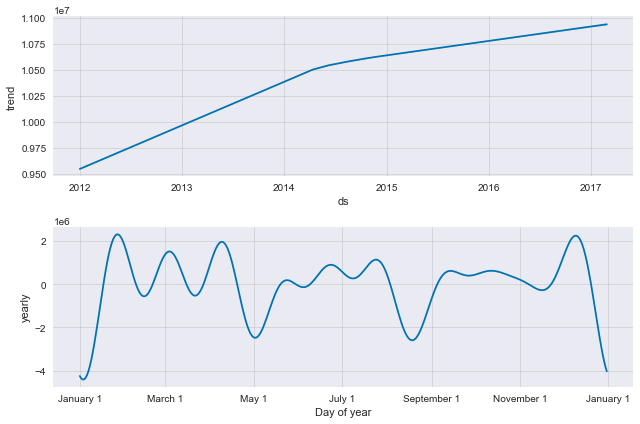

In [300]:
fig2 = m.plot_components(fct)

### Test set vs PROPHET forecast values

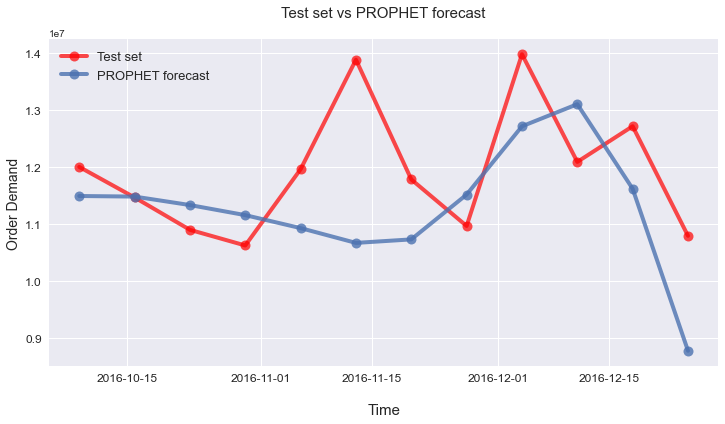

In [301]:
label='PROPHET forecast'
fct_test = prophet_fct_test
title = 'Test set vs PROPHET forecast\n'
def test_setVS_plot(dfp_test, fct_test, label, title): 
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(dfp_test, label='Test set', color='red', linewidth=4, marker='o', markersize=10, alpha=.7)
    ax.plot(dfp_test.index,fct_test, label=label, linewidth=4, marker='o', markersize=10, alpha=.8)
    ax.set_title(title, fontsize=(15))
    ax.legend(loc = 2, fontsize=13)
    ax.tick_params(axis="y", labelsize=12)
    ax.tick_params(axis="x", labelsize=12)
    ax.set_ylabel('Order Demand', fontsize=14)
    ax.set_xlabel('\nTime', fontsize=15)

test_setVS_plot(dfp_test, fct_test, label, title)

### Model Metrics

The PROPHET model performed better than the SARIMA model.

In [302]:
results_PROPHET = forecast_metrics(prophet_fct_test.values, dfp_test.values, 'PROPHET')
results_PROPHET

,Metric,PROPHET
0,RMSE,1.336790e+06
1,RMSE%,1.183505e-01
2,MAE,1.061365e+06
3,MAPE,9.787470e-02


## Forecasting Plot
The plot below was build with the same parametes of the SARIMA forecasting plot. It is displayed the predicted and forecast values by the model on top of the real data points. Again the confidence interval used was 80%.

It is possible to note that the PROPHET model got the seasonality of the data very well and predicts values that would be around the average demand for certain region of data points. It does not try to get the extreme data points.

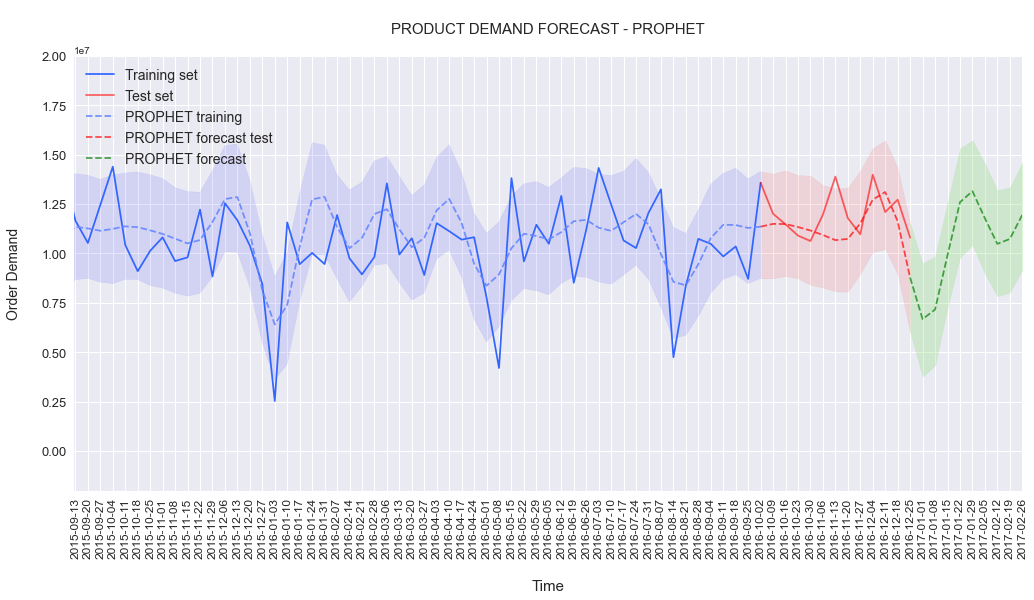

In [303]:
forecasting_plot(forecast.yhat, forecast[['yhat_lower','yhat_upper']], ts_train, ts_test, horizon, alpha,
                title='\nPRODUCT DEMAND FORECASTING - PROPHET\n', ylabel='Order Demand\n', xlabel='\nTime',
                label_train='PROPHET training',label_forecast_test='PROPHET forecast test',
                label_forecast='PROPHET forecast')

# LSTM Neural Network model

Long short-term memory (LSTM) are a specific Recurrent Neural Network. As a Recurrent Neural Network they are especially good for sequences treatment, hence Time-Series. LSTM Networks have the advantage over the classic RNN's of being more robust regarding vanishing/exploding gradients.

Here we will train a LSTM Neural Network to forecast the 12 steps of the test set (ts_test)

In [357]:
#Import the necessary libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler

## Feature Engineering

Neural Networks usually perform better with a lot of data. As the training set has few data points, we are going to create three new variable to give the model more information regarding the seasonality from the data.

 - week: Corresponds to the week number of the year
 - month: Corresponds to the month number of the year
 - new_year: It is equal to 1 when in the first week of the year



In [443]:
#Define dfLSTM from the time series ts_train
dfLSTM = pd.DataFrame(ts_train)

#Generate a week number column
dfLSTM['week'] = dfLSTM.index.weekofyear

#Generate a month number column
dfLSTM['month'] = dfLSTM.index.month

#Generate a new year column
dfLSTM.loc[dfLSTM['week'] == 52, 'new_year'] = 1
dfLSTM.loc[dfLSTM['week'] != 52, 'new_year'] = 0

dfLSTM

,Order_Demand,week,month,new_year
Date,,,,
2012-01-01,28700.0,52,1,1.0
2012-01-08,6263324.0,1,1,0.0
2012-01-15,10770719.0,2,1,0.0
2012-01-22,9664283.0,3,1,0.0
2012-01-29,9798726.0,4,1,0.0
...,...,...,...,...
2016-09-04,10482735.0,35,9,0.0
2016-09-11,9845836.0,36,9,0.0
2016-09-18,10351736.0,37,9,0.0


## Dataset Preparation

Before feeding the LSTM model with data, it is important to reorganize it in a form that the model can ingest.

- First, we split the dfLSTM into a training set and a validation set. The proportion of 60% training and 40% validation was adopted so it is possible to use a relatively large lookback value. Hence, the model will tend be able to generalize better the predictions.


- Second, the data needs to be normalized. Here we will use the MinMaxScaler from Scikit-Learn. The normalization is made after splitting the sets to avoid data leakage.


- And third, we set up the array to feed the model containing the temporal sequences (seq size = lookback) and the response values array (seq size = horizon)


In [359]:
def dataset_prep(dataset, validation_split = 0.2, lookback = 30, horizon = 12):
    '''
    Get the dataset prepared for LSTM training.
    
    arguments
    ----------
    dataset: Dataframe containig the target variable and the interesting features - Shape = (observarions, features).
    validation_split: Split proportion between train/validation sets.
    lookback: Number of steps in the pass the model will take into account.
    horizon: Number of steps in future the model will train to forecast.
    
    return
    ----------
    train_X: Observation values from training set.
    train_y: Target values from training set.
    val_X: Observation values from validation set.
    val_y: Target values from validation set.
    scaler: Object from MinMaxScaler used to normalize the data.
    num_features: Number of features in the dataset
    '''
    

#HELPER FUNCTIONS
    def iterate(data, lookback):
        '''Get the input sequeces'''
        data_X, data_y = [], []
        
        for i in range(len(data) - lookback - horizon): 
            data_X.append(data[ i : i+lookback ]) 
            data_y.append(data[ i+lookback : i+lookback+horizon ])
        return np.array(data_X), np.array(data_y)
    
    
    def to_3D(data):
        '''Reshape the data to LSTM ingestion'''
        if data != []:
            data = data.reshape(data.shape[0], data.shape[1], 1)
        return data
    
    
    #Get the number of features to be input
    num_features = np.array(dataset).shape[1]
    
    #Define a scaler object
    scaler = MinMaxScaler(feature_range=(0,1))    
    
    
#ONE FEATURE DATASET PREP
    if np.array(dataset).ndim == 1:
        
        #Split and scale the dataset - preventing data leakage
        if validation_split == 0:
            train = dataset
            train = scaler.fit_transform(np.array(train).reshape(-1,1))
            val = []
        else:    
            val_size = int(validation_split*len(dataset))
            train = dataset[:-val_size]
            train = scaler.fit_transform(np.array(train).reshape(-1,1))

            val = dataset[-val_size:]
            val = scaler.transform(np.array(val).reshape(-1,1))


        train_X, train_y = iterate(np.array(train).reshape(-1,), lookback)
        val_X, val_y = iterate(np.array(val).reshape(-1,), lookback)

        train_X = to_3D(train_X)
        val_X = to_3D(val_X)
    
    
#MULTI-FEATURE DATASET PREP
    else: 
        
    #Split and scale the dataset
        if validation_split == 0:
            train = dataset
            train = scaler.fit_transform(np.array(train))
            val = []
        else:    
            val_size = int(validation_split*len(dataset))
            train = dataset[:-val_size]
            train = scaler.fit_transform(np.array(train))

            val = dataset[-val_size:]
            val = scaler.transform(np.array(val))

        
    #Generate the sequences       
        train_X = []
        train_y = []
        val_X = []
        val_y = []
        
        #Get the values for each feature
        for i in range(num_features):
            train_X_feature, train_y_feature = iterate(np.array(train)[:,i], lookback)
            train_X.append(train_X_feature)
            train_y.append(train_y_feature)
            if val != []:
                val_X_feature, val_y_feature = iterate(np.array(val)[:,i], lookback)
                val_X.append(val_X_feature)
                val_y.append(val_y_feature)


        train_X = np.array(train_X); train_y = np.array(train_y) #From list to array
        train_X = train_X.transpose(1,2,0)
        train_y = train_y[0,:,:]
        
        if val != []:    
            val_X = np.array(val_X); val_y = np.array(val_y) #From list to array
            val_X = val_X.transpose(1,2,0)
            val_y = val_y[0,:,:]
        
    return train_X, train_y, val_X, val_y, scaler, num_features

In [360]:
#Number of steps in the pass the model will take into account
lookback = 82

#Number of steps in future the model will train to forecast
horizon = 12

#Split proportion between train/validation sets
validation_split = 0.4

#Get the prepared data to train the model
train_X, train_y, val_X, val_y, scaler, num_features = dataset_prep(dfLSTM,
                                                                    validation_split = validation_split,
                                                                    lookback = lookback,
                                                                    horizon = horizon)

## Network Architecture

The network architecture and hyperparameters were defined after a few manual iterations, therefore there may be a lot of room for improvement.


In [415]:
#Define the model architecture
model = Sequential()

model.add(LSTM(32,dropout=0.2, return_sequences=True, input_shape=(train_X.shape[1],num_features)))
model.add(LSTM(548,dropout=0.2, return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(LSTM(64,dropout=0.2, return_sequences=False))

model.add(Dense(horizon, kernel_initializer='zeros'))


#Compile the model - Define: Loss, Optimizer and Learning Rate
model.compile(loss = 'mean_squared_error', metrics='mae', optimizer = keras.optimizers.RMSprop(learning_rate=0.001))

In [445]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 82, 32)            4736      
_________________________________________________________________
lstm_31 (LSTM)               (None, 82, 548)           1273552   
_________________________________________________________________
batch_normalization_9 (Batch (None, 82, 548)           2192      
_________________________________________________________________
lstm_32 (LSTM)               (None, 64)                156928    
_________________________________________________________________
dense_10 (Dense)             (None, 12)                780       
Total params: 1,438,188
Trainable params: 1,437,092
Non-trainable params: 1,096
_________________________________________________________________


## Callback functions

In [430]:
path_checkpoint = 'DemandForecastingLSTM.keras'

#Define a file to save the best models
callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath = path_checkpoint,
                                                      monitor = 'val_loss', save_best_only=True, verbose=0)

#Define a metric to stop the training if not evolving
callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=1)

#Reduce the learning rate if 'val_loss' is not improving
callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.85, min_lr=1e-4, patience=17, verbose=1)

#Create a list with the callback functions to pass to keras
callbacks = [callback_checkpoint,
             callback_reduce_lr,
             callback_early_stopping]


## Model Training

In [417]:
#Fit the model
history = model.fit(train_X, train_y,
                    validation_data=(val_X, val_y),
                    callbacks = callbacks,
                    epochs=500,
                    batch_size=10,
                    verbose=2)

Epoch 1/500
6/6 - 1s - loss: 0.3185 - mae: 0.5084 - val_loss: 0.0802 - val_mae: 0.2596 - lr: 0.0010
Epoch 2/500
6/6 - 0s - loss: 0.0333 - mae: 0.1294 - val_loss: 0.0321 - val_mae: 0.1510 - lr: 0.0010
Epoch 3/500
6/6 - 0s - loss: 0.0304 - mae: 0.1182 - val_loss: 0.0351 - val_mae: 0.1581 - lr: 0.0010
Epoch 4/500
6/6 - 0s - loss: 0.0313 - mae: 0.1220 - val_loss: 0.0357 - val_mae: 0.1533 - lr: 0.0010
Epoch 5/500
6/6 - 0s - loss: 0.0311 - mae: 0.1224 - val_loss: 0.0337 - val_mae: 0.1518 - lr: 0.0010
Epoch 6/500
6/6 - 0s - loss: 0.0299 - mae: 0.1180 - val_loss: 0.0381 - val_mae: 0.1643 - lr: 0.0010
Epoch 7/500
6/6 - 0s - loss: 0.0310 - mae: 0.1205 - val_loss: 0.0361 - val_mae: 0.1566 - lr: 0.0010
Epoch 8/500
6/6 - 0s - loss: 0.0317 - mae: 0.1219 - val_loss: 0.0411 - val_mae: 0.1734 - lr: 0.0010
Epoch 9/500
6/6 - 0s - loss: 0.0314 - mae: 0.1232 - val_loss: 0.0349 - val_mae: 0.1474 - lr: 0.0010
Epoch 10/500
6/6 - 0s - loss: 0.0311 - mae: 0.1228 - val_loss: 0.0271 - val_mae: 0.1320 - lr: 0.0010

Epoch 79/500
6/6 - 0s - loss: 0.0278 - mae: 0.1186 - val_loss: 0.0614 - val_mae: 0.2244 - lr: 7.2250e-04
Epoch 80/500
6/6 - 0s - loss: 0.0278 - mae: 0.1171 - val_loss: 0.0446 - val_mae: 0.1862 - lr: 7.2250e-04
Epoch 81/500
6/6 - 0s - loss: 0.0276 - mae: 0.1196 - val_loss: 0.0267 - val_mae: 0.1322 - lr: 7.2250e-04
Epoch 82/500
6/6 - 0s - loss: 0.0277 - mae: 0.1182 - val_loss: 0.0383 - val_mae: 0.1617 - lr: 7.2250e-04
Epoch 83/500
6/6 - 0s - loss: 0.0275 - mae: 0.1178 - val_loss: 0.0461 - val_mae: 0.1865 - lr: 7.2250e-04
Epoch 84/500
6/6 - 0s - loss: 0.0276 - mae: 0.1188 - val_loss: 0.0306 - val_mae: 0.1437 - lr: 7.2250e-04
Epoch 85/500
6/6 - 0s - loss: 0.0274 - mae: 0.1183 - val_loss: 0.0356 - val_mae: 0.1576 - lr: 7.2250e-04
Epoch 86/500
6/6 - 0s - loss: 0.0273 - mae: 0.1179 - val_loss: 0.3138 - val_mae: 0.5329 - lr: 7.2250e-04
Epoch 87/500
6/6 - 0s - loss: 0.0275 - mae: 0.1177 - val_loss: 0.0312 - val_mae: 0.1461 - lr: 7.2250e-04
Epoch 88/500

Epoch 00088: ReduceLROnPlateau reducing l

Epoch 154/500
6/6 - 0s - loss: 0.0251 - mae: 0.1141 - val_loss: 0.0255 - val_mae: 0.1274 - lr: 3.7715e-04
Epoch 155/500
6/6 - 0s - loss: 0.0256 - mae: 0.1153 - val_loss: 0.0258 - val_mae: 0.1289 - lr: 3.7715e-04
Epoch 156/500
6/6 - 0s - loss: 0.0250 - mae: 0.1146 - val_loss: 0.0207 - val_mae: 0.1113 - lr: 3.7715e-04
Epoch 157/500
6/6 - 0s - loss: 0.0254 - mae: 0.1149 - val_loss: 0.0222 - val_mae: 0.1165 - lr: 3.7715e-04
Epoch 158/500
6/6 - 0s - loss: 0.0257 - mae: 0.1146 - val_loss: 0.0217 - val_mae: 0.1150 - lr: 3.7715e-04
Epoch 159/500
6/6 - 0s - loss: 0.0252 - mae: 0.1144 - val_loss: 0.0227 - val_mae: 0.1171 - lr: 3.7715e-04
Epoch 160/500
6/6 - 0s - loss: 0.0254 - mae: 0.1148 - val_loss: 0.0222 - val_mae: 0.1158 - lr: 3.7715e-04
Epoch 161/500
6/6 - 0s - loss: 0.0255 - mae: 0.1153 - val_loss: 0.0225 - val_mae: 0.1151 - lr: 3.7715e-04
Epoch 162/500
6/6 - 0s - loss: 0.0249 - mae: 0.1143 - val_loss: 0.0324 - val_mae: 0.1458 - lr: 3.7715e-04
Epoch 163/500
6/6 - 0s - loss: 0.0251 - mae: 0

Epoch 231/500
6/6 - 0s - loss: 0.0232 - mae: 0.1108 - val_loss: 0.0196 - val_mae: 0.1110 - lr: 3.2058e-04
Epoch 232/500
6/6 - 0s - loss: 0.0234 - mae: 0.1104 - val_loss: 0.0201 - val_mae: 0.1098 - lr: 3.2058e-04
Epoch 233/500
6/6 - 0s - loss: 0.0236 - mae: 0.1118 - val_loss: 0.0195 - val_mae: 0.1096 - lr: 3.2058e-04
Epoch 234/500
6/6 - 0s - loss: 0.0241 - mae: 0.1129 - val_loss: 0.0207 - val_mae: 0.1108 - lr: 3.2058e-04
Epoch 235/500
6/6 - 0s - loss: 0.0234 - mae: 0.1109 - val_loss: 0.0227 - val_mae: 0.1158 - lr: 3.2058e-04
Epoch 236/500
6/6 - 0s - loss: 0.0232 - mae: 0.1101 - val_loss: 0.0199 - val_mae: 0.1104 - lr: 3.2058e-04
Epoch 237/500
6/6 - 0s - loss: 0.0230 - mae: 0.1092 - val_loss: 0.0219 - val_mae: 0.1148 - lr: 3.2058e-04
Epoch 238/500

Epoch 00238: ReduceLROnPlateau reducing learning rate to 0.0002724905527429655.
6/6 - 0s - loss: 0.0240 - mae: 0.1124 - val_loss: 0.0214 - val_mae: 0.1158 - lr: 3.2058e-04
Epoch 239/500
6/6 - 0s - loss: 0.0227 - mae: 0.1095 - val_loss: 0.0209 

Epoch 306/500
6/6 - 0s - loss: 0.0213 - mae: 0.1061 - val_loss: 0.0191 - val_mae: 0.1086 - lr: 1.9687e-04
Epoch 307/500
6/6 - 0s - loss: 0.0219 - mae: 0.1071 - val_loss: 0.0190 - val_mae: 0.1087 - lr: 1.9687e-04
Epoch 308/500
6/6 - 0s - loss: 0.0207 - mae: 0.1052 - val_loss: 0.0186 - val_mae: 0.1094 - lr: 1.9687e-04
Epoch 309/500
6/6 - 0s - loss: 0.0215 - mae: 0.1057 - val_loss: 0.0209 - val_mae: 0.1128 - lr: 1.9687e-04
Epoch 310/500
6/6 - 0s - loss: 0.0209 - mae: 0.1057 - val_loss: 0.0211 - val_mae: 0.1124 - lr: 1.9687e-04
Epoch 311/500

Epoch 00311: ReduceLROnPlateau reducing learning rate to 0.00016734325545257888.
6/6 - 0s - loss: 0.0213 - mae: 0.1065 - val_loss: 0.0197 - val_mae: 0.1099 - lr: 1.9687e-04
Epoch 312/500
6/6 - 0s - loss: 0.0212 - mae: 0.1051 - val_loss: 0.0184 - val_mae: 0.1074 - lr: 1.6734e-04
Epoch 313/500
6/6 - 0s - loss: 0.0220 - mae: 0.1079 - val_loss: 0.0185 - val_mae: 0.1078 - lr: 1.6734e-04
Epoch 314/500
6/6 - 0s - loss: 0.0203 - mae: 0.1035 - val_loss: 0.0185

Epoch 381/500
6/6 - 0s - loss: 0.0195 - mae: 0.1002 - val_loss: 0.0181 - val_mae: 0.1075 - lr: 1.2091e-04
Epoch 382/500
6/6 - 0s - loss: 0.0200 - mae: 0.1032 - val_loss: 0.0185 - val_mae: 0.1075 - lr: 1.2091e-04
Epoch 383/500
6/6 - 0s - loss: 0.0195 - mae: 0.1003 - val_loss: 0.0181 - val_mae: 0.1069 - lr: 1.2091e-04
Epoch 384/500
6/6 - 0s - loss: 0.0189 - mae: 0.0995 - val_loss: 0.0181 - val_mae: 0.1068 - lr: 1.2091e-04
Epoch 385/500

Epoch 00385: ReduceLROnPlateau reducing learning rate to 0.00010276967877871357.
6/6 - 0s - loss: 0.0192 - mae: 0.1006 - val_loss: 0.0181 - val_mae: 0.1083 - lr: 1.2091e-04
Epoch 386/500
6/6 - 0s - loss: 0.0192 - mae: 0.1005 - val_loss: 0.0181 - val_mae: 0.1086 - lr: 1.0277e-04
Epoch 387/500
6/6 - 0s - loss: 0.0188 - mae: 0.0992 - val_loss: 0.0179 - val_mae: 0.1082 - lr: 1.0277e-04
Epoch 388/500
6/6 - 0s - loss: 0.0189 - mae: 0.0989 - val_loss: 0.0180 - val_mae: 0.1075 - lr: 1.0277e-04
Epoch 389/500
6/6 - 0s - loss: 0.0193 - mae: 0.1011 - val_loss: 0.0177

Epoch 457/500
6/6 - 0s - loss: 0.0187 - mae: 0.0994 - val_loss: 0.0177 - val_mae: 0.1065 - lr: 1.0000e-04
Epoch 458/500
6/6 - 0s - loss: 0.0181 - mae: 0.0972 - val_loss: 0.0176 - val_mae: 0.1082 - lr: 1.0000e-04
Epoch 459/500
6/6 - 0s - loss: 0.0190 - mae: 0.0998 - val_loss: 0.0182 - val_mae: 0.1083 - lr: 1.0000e-04
Epoch 460/500
6/6 - 0s - loss: 0.0183 - mae: 0.0978 - val_loss: 0.0173 - val_mae: 0.1054 - lr: 1.0000e-04
Epoch 461/500
6/6 - 0s - loss: 0.0190 - mae: 0.0999 - val_loss: 0.0176 - val_mae: 0.1067 - lr: 1.0000e-04
Epoch 462/500
6/6 - 0s - loss: 0.0179 - mae: 0.0965 - val_loss: 0.0180 - val_mae: 0.1075 - lr: 1.0000e-04
Epoch 463/500
6/6 - 0s - loss: 0.0187 - mae: 0.0984 - val_loss: 0.0175 - val_mae: 0.1076 - lr: 1.0000e-04
Epoch 464/500
6/6 - 0s - loss: 0.0181 - mae: 0.0975 - val_loss: 0.0175 - val_mae: 0.1060 - lr: 1.0000e-04
Epoch 465/500
6/6 - 0s - loss: 0.0182 - mae: 0.0975 - val_loss: 0.0185 - val_mae: 0.1082 - lr: 1.0000e-04
Epoch 466/500
6/6 - 0s - loss: 0.0181 - mae: 0

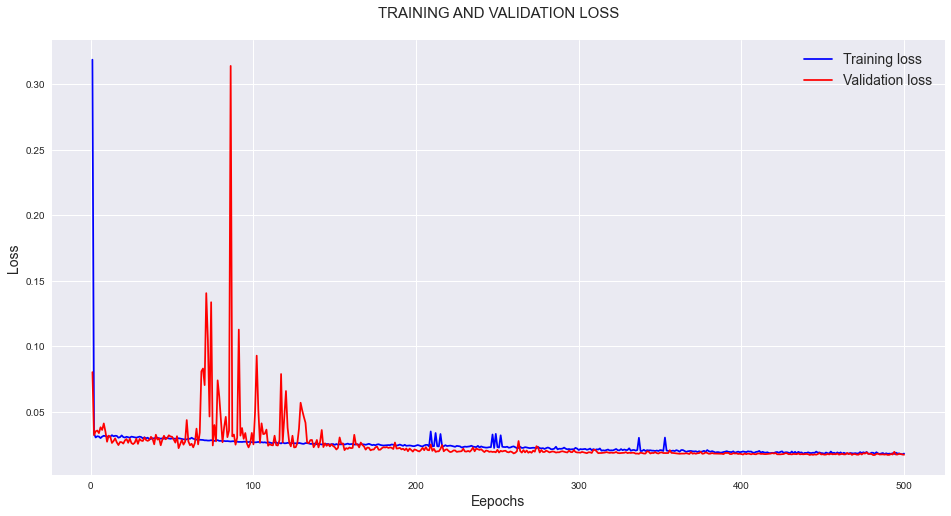

In [418]:
#Plot the Loss and Validation Loss values

#Loss values
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

#Plot settings
plt.figure(figsize=(16,8))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('TRAINING AND VALIDATION LOSS\n', fontsize = 15)
# plt.ylim(0,0.04)
# plt.xlim(-10,510)
plt.xlabel('Eepochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)

## Model Diagnostics

### Model Evaluation

In [431]:
#Load the model weights from the checkpoint ('path_checkpoint' file)

try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [432]:
#Evaluate the model - Display the metrics from the checkpoint model 
result = model.evaluate(x= val_X, y= val_y)

1/1 [==============================] - 0s 997us/step - loss: 0.0155 - mae: 0.1045


### Test set vs LSTM forecast values

In [433]:
def forecastLSTM(model, past_data, scaler,  lookback):
    '''
    Get the forecast for horizon using a input sequence of data.
    
    
    arguments
    ----------
    model: Trained model.
    past_data: Input sequence (Last values from the training/validation data). Must be >= lookback. Non-scaled.
    scaler: Object from MinMaxScaler used to normalize the data.
    lookback: = Input sequence size (Must be the value used to train the model).
    
    return
    ----------
    pred: horizon predictions denormalized.
    '''   
    
    #Scale and reshape the data
    input_seq = np.array(past_data)
    input_seq = scaler.transform(input_seq)
    input_seq = input_seq[-lookback:, :] # Get the last values from all features (size = lookback) to make the first prediction
    input_seq = np.expand_dims(input_seq, axis=0)
    
    #Get predictions
    pred = model.predict(input_seq)    
    pred = np.transpose(np.array(pred))
    
    #Invert scale
    dummy = np.zeros([pred.shape[0],3])
    dummy = np.concatenate((pred, dummy), axis=1)
    pred = scaler.inverse_transform(dummy)
    pred = pred[:,0]
    
    return pred

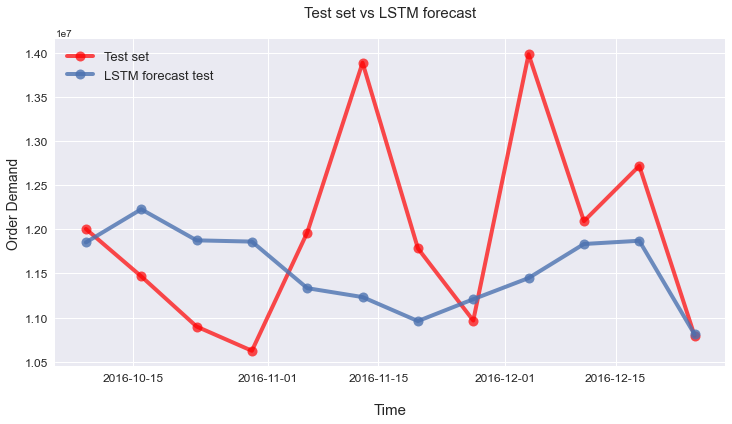

In [434]:
#Get the forecast for the test set period
fct_test_LSTM = forecastLSTM(model, dfLSTM, lookback = lookback, scaler=scaler)

#Plot the forecast over the test set
label = 'LSTM forecast test'
title = 'Test set vs LSTM forecast\n'
test_setVS_plot(ts_test[1:], fct_test_LSTM, label, title)

### Model metrics

The LSTM model ended up having the best performance.

In [446]:
#Measure fct_test_LSTM
results_LSTM = forecast_metrics(fct_test_LSTM, dfp_test.values[1:], 'LSTM')
results_LSTM

,Metric,LSTM
0,RMSE,1.258673e+06
1,RMSE%,1.090417e-01
2,MAE,9.701811e+05
3,MAPE,8.433891e-02


## Forecasting Plot

The Forecasting Plot for the LSTM model will be slightly different. We do not have the confidence intervals, although it is possible to get it, it is beyond the scope of this study. 

- The real data points from the training set are plotted in blue and the real data points from the test set are plotted in red. These are represented by continuous lines.


- The green dashed line is the 1-Step prediction from the model, having as input the temporal sequence from dfLSTM right before the prediction.


- The red dashed line is the 12-Step prediction from the LSTM model having as input the temporal sequence from dfLSTM right before the prediction (in this case the final points from dfLSTM).


- The orange dashed line is the 12-Step prediction from the LSTM model having as input the temporal sequence from dfLSTM right before the prediction. Is was plotted a few times over the 1-Step predictions to show how the model would behave giving a full predictions at that point.


In [436]:
def predictLSTM(model, input_data, scaler,  lookback, horizon=12):
    '''
    
    Get the predictions for the training/test data.
    The first sequence of data will not be computaded (size = lookback) as it is needed to generate the predictions.
    
    
    arguments
    ----------
    model: Trained model.
    input_data: = Training/Test data. Must be >= lookback.
    scaler: Object from MinMaxScaler used to normalize the data.
    lookback: Input sequence size.
    
    return
    ----------
    pred_1step: 1-step predictions denormalized.
    pred_full: horizon size predictions denormalized.
    '''  
    
    input_data = np.array(input_data)
    
    #Data to be plotted
    true_data = input_data.copy() 
    true_data = true_data[:,0]
    
    #Scale the data - shape = (len,num of features)
    input_data = scaler.transform(input_data) #Scale the data
    
    #Prepare data for the LSTM ingestion
    input_seq = []
        
    for feat in range(num_features):   
        _ = []
        for line in range(len(input_data) - lookback - 1): 
            _.append( input_data[ (line) : (line + lookback), feat ])
        input_seq.append(_)
    
    input_seq = np.array(input_seq)
    input_seq = np.transpose(input_seq, axes=(1,2,0))

    
    
    #Get the predictions  -    input_seq.shape  = (observation, lookback, num of features)
    pred_1step = []
    pred_full = []
    
    for i in range(input_seq.shape[0]):
        pred_i = model.predict(np.expand_dims(input_seq[i,:,:], axis=0))
        pred_1step.append(pred_i[0,0])
        pred_full.append(pred_i[0,:])
        
#Invert scale from pred_1step
    pred_1step = np.array(pred_1step).reshape(-1,1)
    dummy = np.zeros([pred_1step.shape[0],input_data.shape[1]-1])
    dummy = np.concatenate((pred_1step, dummy), axis=1)
    pred_1step = scaler.inverse_transform(dummy)
    pred_1step = pred_1step[:,0]
    
    
#Invert scale from pred_full -    pred_full.shape  = (observation, horizon)
    pred_full = np.array(pred_full)
    
    for i in range(pred_full.shape[0]):
        dummy_pred = pred_full[i,:]
        dummy_zeros = np.zeros([dummy_pred.shape[0], input_data.shape[1]-1])
        dummy_zeros = np.concatenate((dummy_pred.reshape(-1,1), dummy_zeros), axis=1)
        dummy_pred = scaler.inverse_transform(dummy_zeros)
        pred_full[i,:] = dummy_pred[:,0]
        
    return pred_1step, pred_full

In [437]:
#Get predictions from the LSTM model for the train + validation sets (dfLSTM)
predict_train_LSTM, pred_full = predictLSTM(model, dfLSTM, lookback = lookback, scaler=scaler)

Text(0, 0.5, 'Order Demand')

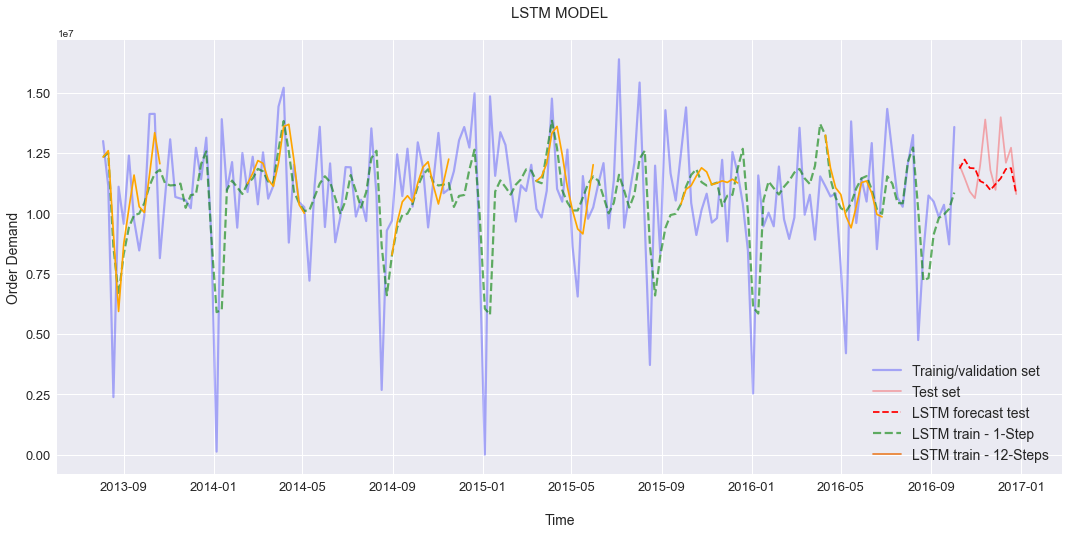

In [451]:
#Plot LSTM model 1-Step predictions over the real dataset.
#Plot the full predictions every 28 steps (orange lines)
#Plot the test set and the LSTM model forecast

fig, ax = plt.subplots(figsize=(18,8))

#Real data
ax.plot(dfLSTM.Order_Demand[lookback+1:], label='Trainig/validation set', color = 'blue', alpha=0.3, linewidth=2.2)
ax.plot(ts_test[1:], label='Test set', color='red', alpha=0.3)

#LSTM model forecast
ax.plot(ts_test.index[1:], fct_test_LSTM, label='LSTM forecast test', color='red', linestyle='--')

#LSTM model predictions - 1-Step
ax.plot(dfLSTM.index[lookback+1:], predict_train_LSTM, label='LSTM train - 1-Step',
        color='green', alpha=0.6, linestyle='--', linewidth=2.2)

#LSTM model predictions - FULL (horizon)-Steps
for i in range(0, len(dfLSTM)-lookback-1-horizon, 28):
    ax.plot(dfLSTM.index[lookback+1+i:lookback+1+i+horizon], pred_full[i,:], color = 'orange', linewidth=1.7)

    
#Plot settings
ax.plot(ts_test.index[1],ts_test[1], color='#eb8334', label='LSTM train - 12-Steps')
ax.set_title('LSTM MODEL\n', fontsize=(15))
ax.tick_params(axis="y", labelsize=13)
ax.tick_params(axis="x", labelsize=13)
ax.legend(fontsize=(14))
ax.set_xlabel('\nTime\n', fontsize=14)
ax.set_ylabel('Order Demand', fontsize=14)

# Wrapping up

The overall results table and graph below show that the LSTM Neural Network performed better than the other models in this data set. Note that the test set is quite small, containing only 12 points, so some randomness may be present. Even though there was not a lot of data for training, the model got good predictions. With a Grid Search and fine tuning, it might possible to achieve even better results. The downside is that it is a computationally heavy, complex, hard to build and interpret model.

The PROPHET model on the other hand, read the data seasonality extremely well and was able to achieve rather good results. It adapted well to this data set characteristics, and it is simple and fast to build.

The SARIMA model still was better than the baseline model, but did not achieve the best results. It would be interesting to evaluate its predictions over a larger test set, as the poor performance could be only due to randomness. Also, working on the data preprocessing might improve the results.

The next step of this study is to explore a hybrid method of exponential smoothing and recurrent neural network described by Slawek Smyl in his paper.


In [439]:
#Create a baseline model (mean from training data)
baseline = np.full(fill_value = dfLSTM.Order_Demand.values[1:].mean(), shape = fct_test_LSTM.shape)
results_beaseline = forecast_metrics(baseline, dfp_test.values[1:], 'Baseline (mean)')

In [440]:
#Measure fct_test_LSTM
results_LSTM = forecast_metrics(fct_test_LSTM, dfp_test.values[1:], 'LSTM')

#Create a dataframe for comparison
overall_results = copy.copy(results_beaseline)
overall_results['LSTM'] = results_LSTM['LSTM']
overall_results['PROPHET'] = results_PROPHET['PROPHET']
overall_results['SARIMA'] = results_SARIMA['SARIMA']



,Metric,Baseline (mean),LSTM,PROPHET,SARIMA
0,RMSE,1.887894e+06,1.258673e+06,1.336790e+06,1.899109e+06
1,RMSE%,1.813793e-01,1.090417e-01,1.183505e-01,1.591595e-01
2,MAE,1.517018e+06,9.701811e+05,1.061365e+06,1.501583e+06
3,MAPE,1.457474e-01,8.433891e-02,9.787470e-02,1.250573e-01


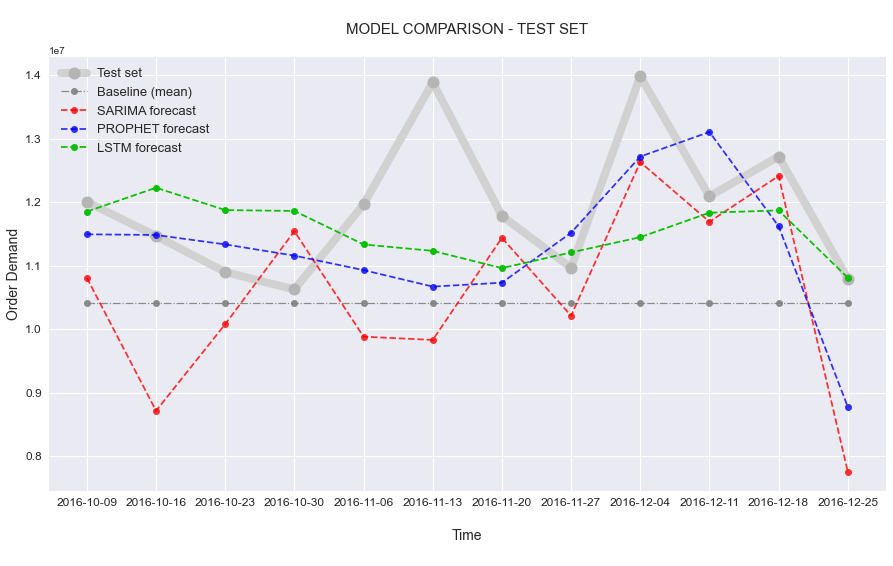

In [453]:
#plot test set
fig, ax = plt.subplots(figsize=(15,8))

#True values
ax.plot(ts_test[1:], label='Test set', linewidth=8, color='#d1d1d1', marker='o', markersize=12, markerfacecolor='#b5b5b5')

#Baseline model
ax.plot(ts_test.index[1:], baseline, label='Baseline (mean)', alpha=0.9,
        linestyle='-.', color ='gray', marker='o', linewidth=1.2)

#SARIMA model
ax.plot(m_ARIMA.get_forecast(ts_test.size).predicted_mean[:-1], label='SARIMA forecast',
        alpha=0.8, linestyle='--', color='red', marker='o')

#PROPHET model
ax.plot(prophet_fct_test, label='PROPHET forecast', alpha=0.8, linestyle='--', color='blue', marker='o')

#LSTM model
ax.plot(ts_test.index[1:], fct_test_LSTM, label='LSTM forecast', alpha=1, linestyle='--', color='#07C000', marker='o')

#Plot settings
ax.grid(b=True, which='minor', axis='both')
ax.set_xticks(ts_test.index[1:])
ax.set_title('\nMODEL COMPARISON - TEST SET\n', fontsize=(15))
ax.legend(fontsize=(13))
ax.tick_params(axis="y", labelsize=12)
ax.tick_params(axis="x", labelsize=12)
ax.set_xlabel('\nTime\n', fontsize=14)
ax.set_ylabel('Order Demand', fontsize=14)


display(overall_results)